# Description
This script compares cest values of regions within network vs between network.


## Import Packages

In [2]:
import os
import glob
import numpy as np
import pandas as pd
#import network_fcon as fc
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf

### Set Variables and Paths

In [3]:
# Set Variables
fieldstrength = '3T'
atlas = 'S1000'
bblids = []
sesids = []
nmaps = ["NMDA", "mGluR5", "GABA","D2"]
diag_scores = ["dx_pscat", "hstatus","sex", "age", "race","ethnic"] # ,"axis1_desc1","axis1_stat1"
diag_details = ["axis1_desc1", "axis1_desc2", "axis1_desc3","axis1_desc4","axis1_desc5", "axis1_desc6"]
#subjlist = subjlist[subjlist['fieldstrength'] == fieldstrength]
#subjs = subjlist['BBLID']

# Import group dataframes and set indices
#subjlist = pd.read_csv(path + "data/pipeline_input_all_subj.csv", sep=',') 
cestmat = pd.read_csv("cest_parcelmat" + fieldstrength + atlas + ".csv", sep=',') 
fcmat = pd.read_csv("fc_parcelmat_" + fieldstrength + atlas + ".csv", sep=',')
rehomat = pd.read_csv("reho_parcelmat" + fieldstrength + atlas + ".csv", sep=',')
grp_df = pd.read_csv("filtered_grp_df" + fieldstrength + atlas + ".csv", sep=',')

# Reformat some dfs
cestmat.set_index('BBLID', inplace = True)
fcmat.set_index('BBLID', inplace = True)
rehomat.set_index('BBLID', inplace = True)
grp_df.set_index('BBLID', inplace = True)


### Create functions

In [3]:
def filter(df, filter_list):
    filtered_columns = [col for col in df.columns if not any(substring in col for substring in filter_list)]
    return df[filtered_columns]

def keep(df, keep_list):
    keep_columns = [col for col in df.columns if any(substring in col for substring in keep_list)]
    return df[keep_columns]   

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            valid_data = df[[col,col2]].dropna()
            if not valid_data.empty:
                _ , p = pearsonr(valid_data[col],valid_data[col2])
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
            else:
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = np.nan
    return p_matrix

### Create correlation matrix and heatmap

In [4]:
# Filter df to exclude subj info
subj_info = ["BBLID"] + ["Session"] + diag_scores + ["count"]
heat_df = filter(grp_df, subj_info)
print(grp_df)

        Unnamed: 0  Session dx_pscat hstatus  sex   age  race  ethnic  \
BBLID                                                                   
20303            0    12276  noDSMdx      NC  1.0  19.2   1.0     2.0   
90217            1    12064      pro     PRO  2.0  25.0   1.0     2.0   
88608            2  motive2      psy     PRO  1.0  25.4   2.0     2.0   
21874            3    12043      NaN     PSY  2.0  24.1   1.0     2.0   
94288            4    11948  noDSMdx      NC  1.0  22.7   1.0     2.0   
...            ...      ...      ...     ...  ...   ...   ...     ...   
135085          81  motive1      pro     PRO  2.0  18.9   1.0     2.0   
135277          82    12277      psy     PSY  2.0  30.2   2.0     2.0   
117397          83    10582    other    PROR  1.0  20.2   2.0     2.0   
87646           84    10496      NaN     NaN  NaN   NaN   NaN     NaN   
93242           85    12525    other    PROR  1.0  25.3   1.0     2.0   

        NZMean_502  NZcount_502  ...  reho_945  re

In [5]:
# Correlation matrix
corr_df=heat_df.corr()
#plt.figure(figsize=(11,9))
#sns.heatmap(corr_df, annot=False, cmap='coolwarm',linewidth=0.7)
#plt.title('Glu-FC Heatmap\nGross network architecture emerges more strongly in fc+reho\nbut also evident in within-Glu correlations')
#plt.tick_params(axis='both', which='major', labelsize=10)
#plt.show()

### Correlation matrix after masking out the significant ones

In [14]:
#pvals = corr_sig(heat_df)
mask01 = np.invert(np.tril(pvals<0.01))
#mask001 = np.invert(np.tril(pvals<0.001))

NameError: name 'pvals' is not defined

In [115]:
#plt.figure(figsize=(11,9))
#sns.heatmap(corr_df, mask=mask01, annot=False, cmap='coolwarm',linewidth=0.7)
#plt.title('Glu-FC Heatmap\nwith a p value threshold of <0.001')
#plt.show()

#masked_cestcorr = cestcorr_df.where(pvals <= .0001)

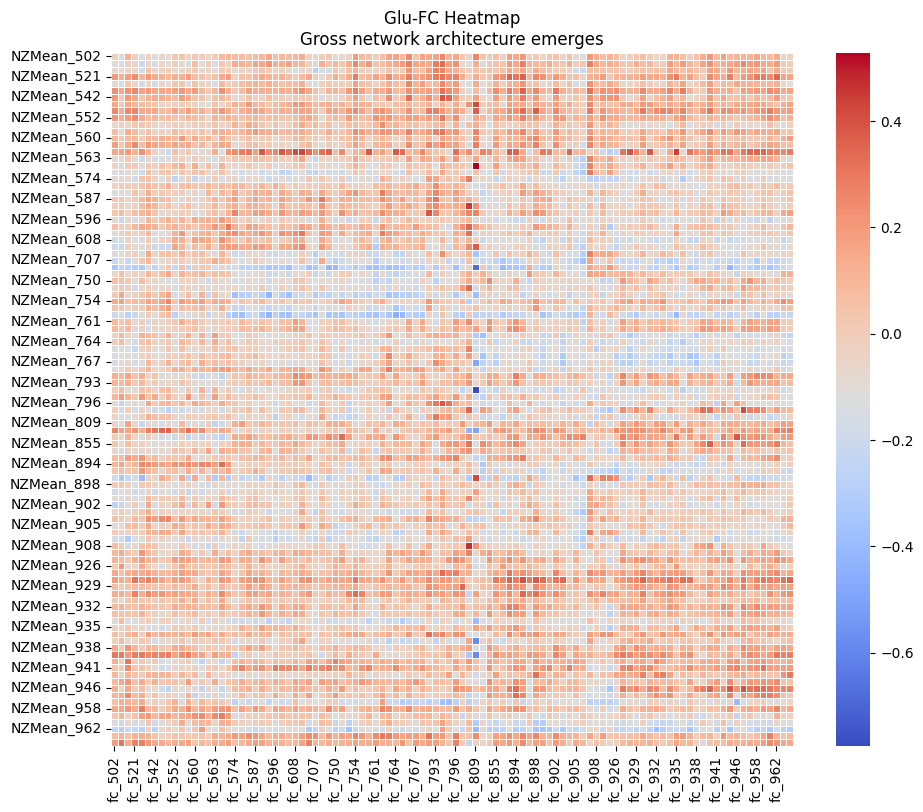

In [6]:
# Correlation matrix GluCEST-GluCEST
cestcorr_df = corr_df.filter(like="NZ", axis=0).filter(like="fc", axis=1)
plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nGross network architecture emerges')
#plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [37]:
## CEST-FC Heat map with network boxes.

# List of parcel names (from the index/columns of your cestcorr_df)
parcel_names = cestcorr_df.index.tolist()

# Define the network numbers to search for
networks = {
    'Visual': [502, 567],
    'Somatomotor': [574, 613],
    'Dorsal Attention': [692, 712],
    'Salience': [750, 797],
    'Limbic': [807, 812 ],
    'Control': [855, 910],
    'Default': [926, 974]
    # Add other networks with their corresponding numbers
}

# Find the indices for each network
network_boundaries = []
for network, nums in networks.items():
    indices = [i for i, name in enumerate(parcel_names) if any(str(num) in name for num in nums)]
    if indices:
        network_boundaries.append((min(indices), max(indices)))

# Plot the heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(cestcorr_df, mask=mask02, annot=False, cmap='coolwarm', linewidth=0.7)

# Draw the black boxes around network boundaries
for (start, end) in network_boundaries:
    plt.plot([start, end+1], [start, start], color='black', lw=2)  # Top line
    plt.plot([start, end+1], [end+1, end+1], color='black', lw=2)  # Bottom line
    plt.plot([start, start], [start, end+1], color='black', lw=2)  # Left line
    plt.plot([end+1, end+1], [start, end+1], color='black', lw=2)  # Right line

plt.title('Glu-FC Heatmap\nGross network architecture emerges')
plt.show()

NameError: name 'mask02' is not defined

<Figure size 1100x900 with 0 Axes>

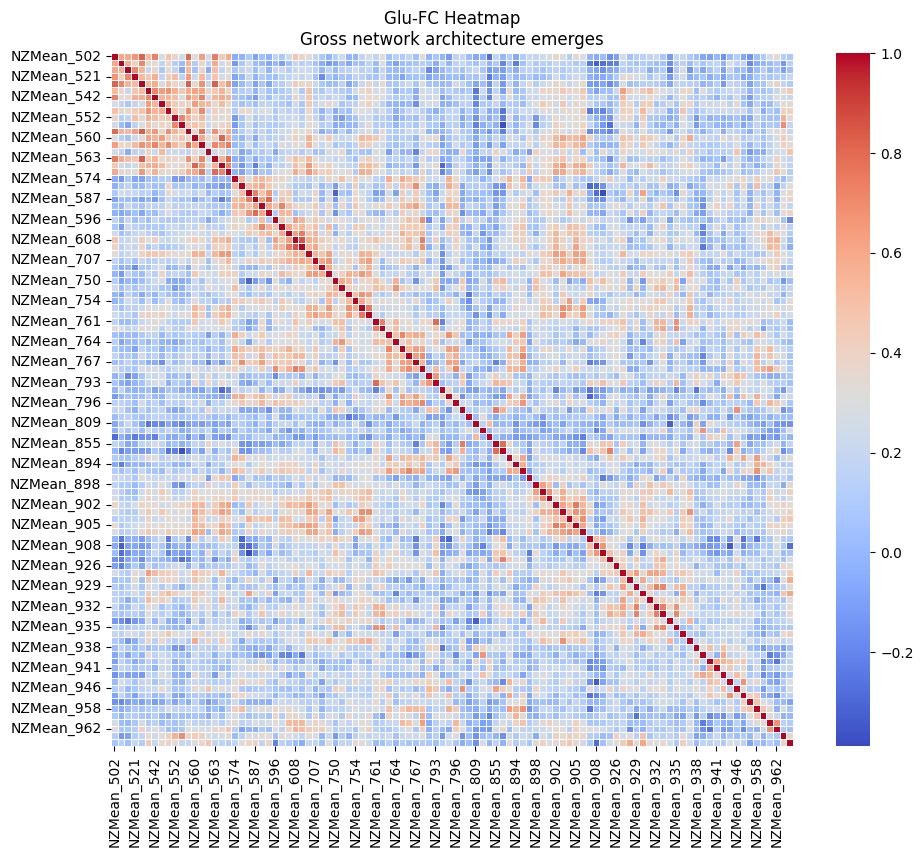

In [38]:
# Correlation matrix GluCEST-GluCEST
cestcorr_df = corr_df.filter(like="NZ", axis=0).filter(like="NZ", axis=1)
plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nGross network architecture emerges')
#plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

(102, 102)


/Users/pecsok/.local/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/pecsok/.local/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1100x900 with 0 Axes>

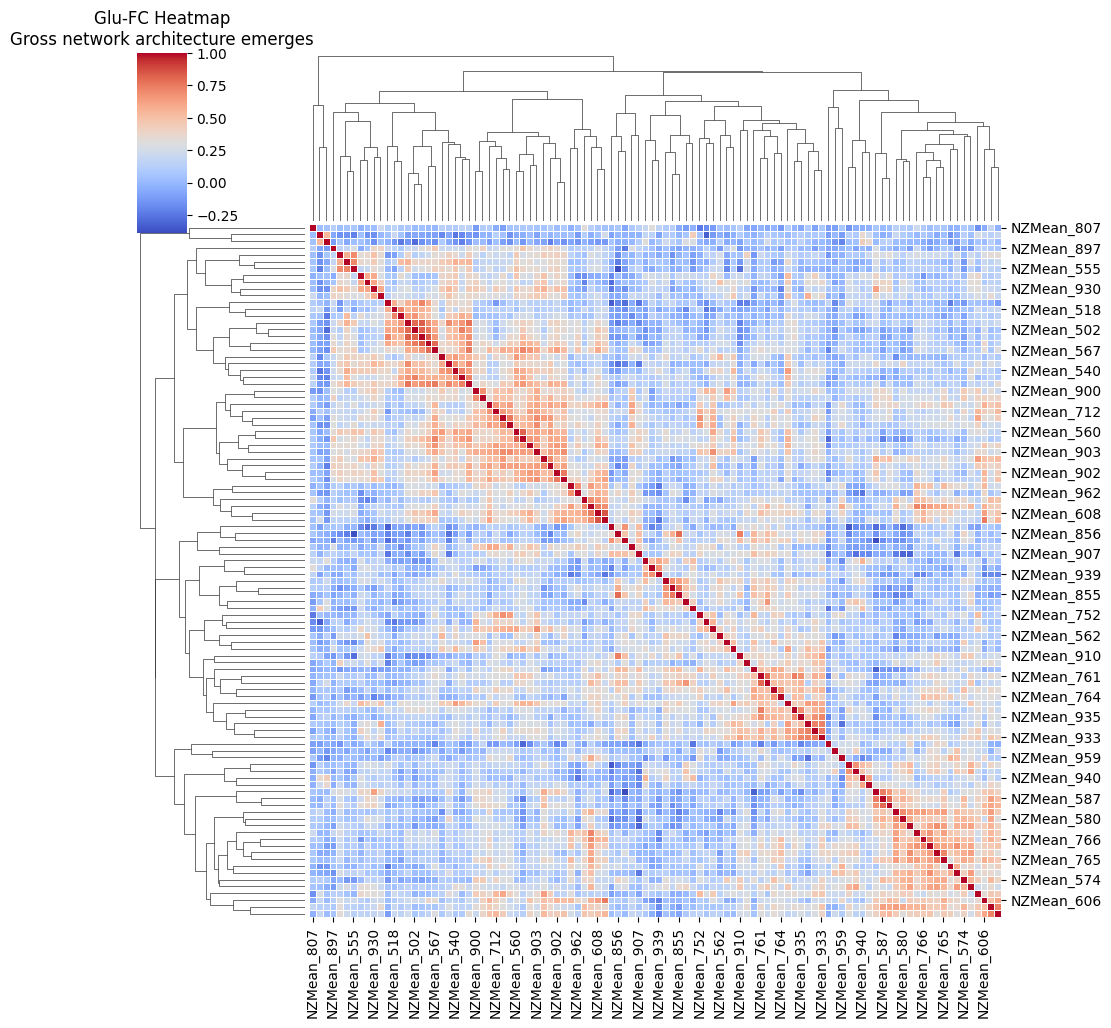

In [39]:
# Correlation matrix GluCEST-GluCEST
cestcorr_df = corr_df.filter(like="NZ", axis=0).filter(like="NZ", axis=1)
print(cestcorr_df.shape)
plt.figure(figsize=(11,9))
sns.clustermap(cestcorr_df, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nGross network architecture emerges')
#plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

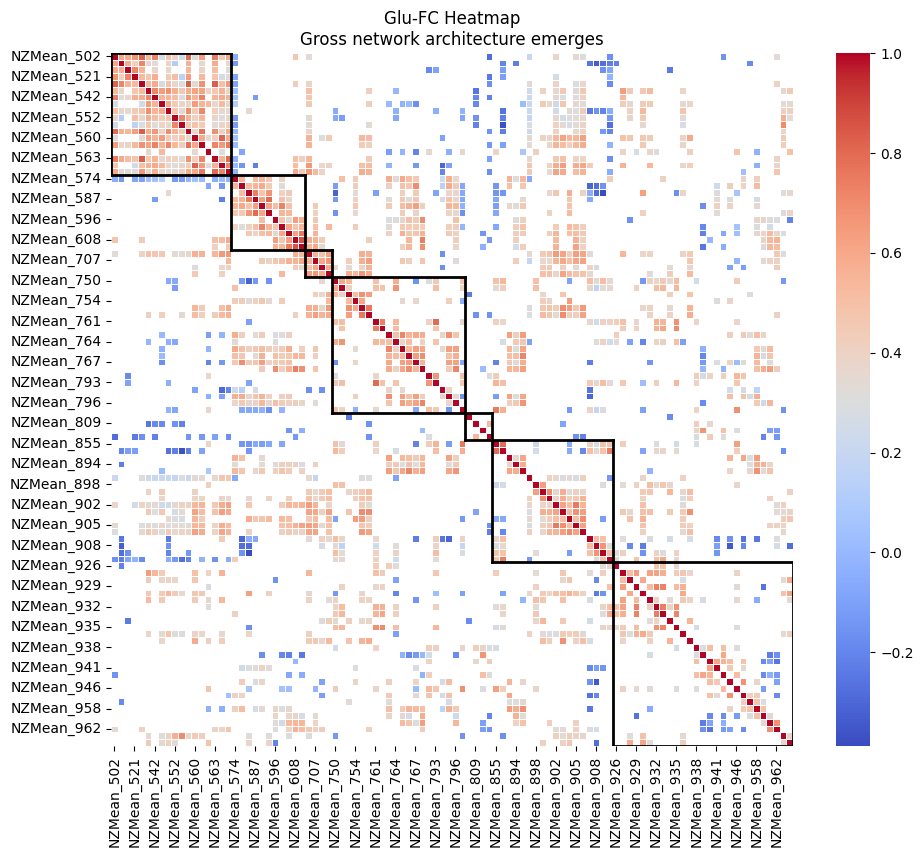

In [41]:
## CEST-FC Heat map with network boxes.

# List of parcel names (from the index/columns of your cestcorr_df)
parcel_names = cestcorr_df.index.tolist()

# Define the network numbers to search for
networks = {
    'Visual': [502, 567],
    'Somatomotor': [574, 613],
    'Dorsal Attention': [692, 712],
    'Salience': [750, 797],
    'Limbic': [807, 812 ],
    'Control': [855, 910],
    'Default': [926, 974]
    # Add other networks with their corresponding numbers
}

# Find the indices for each network
network_boundaries = []
for network, nums in networks.items():
    indices = [i for i, name in enumerate(parcel_names) if any(str(num) in name for num in nums)]
    if indices:
        network_boundaries.append((min(indices), max(indices)))

# Plot the heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(cestcorr_df, mask=mask02, annot=False, cmap='coolwarm',linewidth=0.7)

# Draw the black boxes around network boundaries
for (start, end) in network_boundaries:
    plt.plot([start, end+1], [start, start], color='black', lw=2)  # Top line
    plt.plot([start, end+1], [end+1, end+1], color='black', lw=2)  # Bottom line
    plt.plot([start, start], [start, end+1], color='black', lw=2)  # Left line
    plt.plot([end+1, end+1], [start, end+1], color='black', lw=2)  # Right line

plt.title('Glu-FC Heatmap\nGross network architecture emerges')
plt.show()

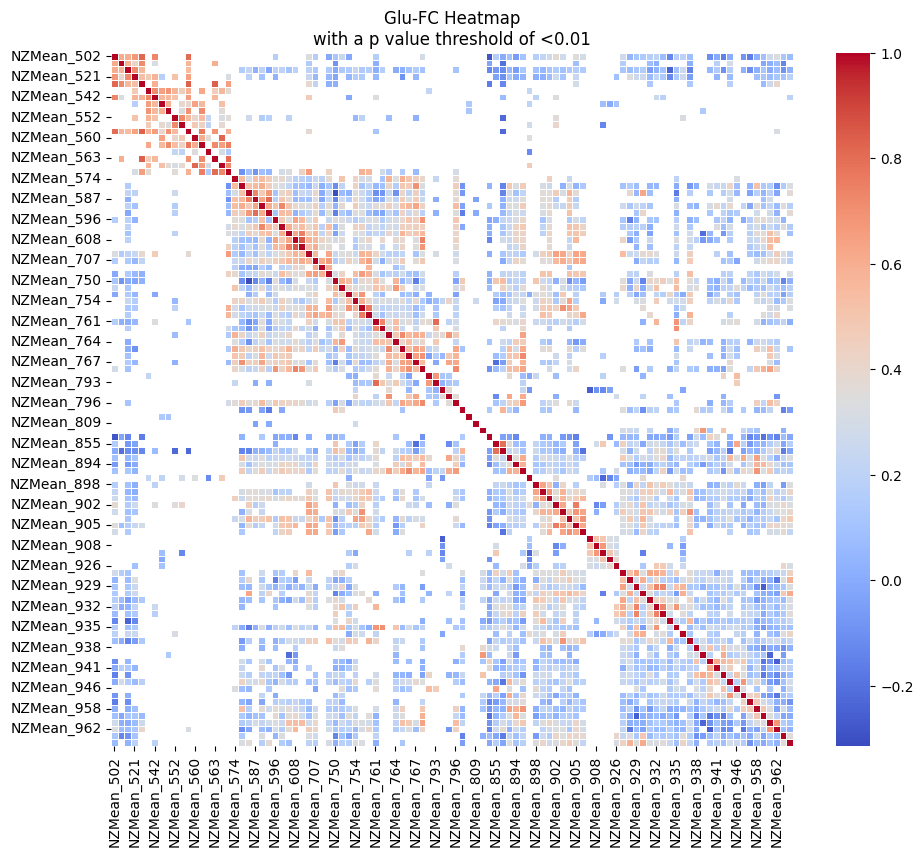

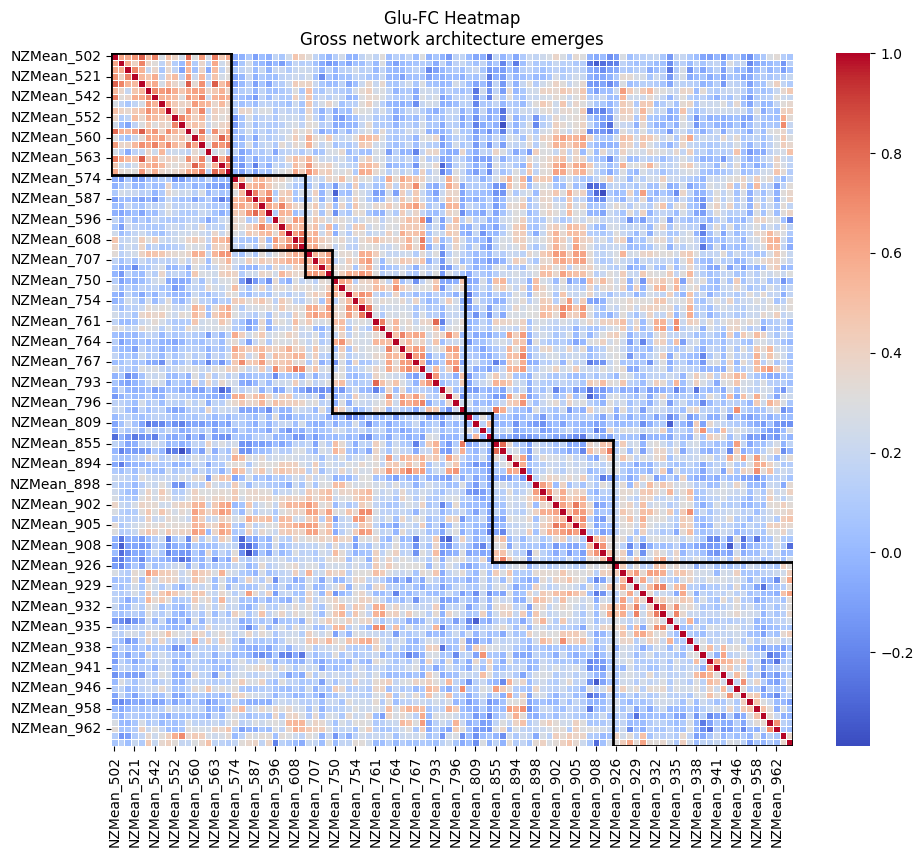

In [42]:
## Heat map with network boxes.

# Keep only signficant values
cestfc = corr_df.filter(like="NZ", axis=0).filter(like="fc", axis=1)
pvals = corr_sig(cestfc)
pvals
mask01 = np.invert(np.tril(pvals<0.01))
mask02 = np.invert(pvals<0.0000001)


plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, mask=mask02, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nwith a p value threshold of <0.01')
plt.show()



# List of parcel names (from the index/columns of your cestcorr_df)
parcel_names = cestcorr_df.index.tolist()

# Define the network numbers to search for
networks = {
    'Visual': [502, 567],
    'Somatomotor': [574, 613],
    'Dorsal Attention': [692, 712],
    'Salience': [750, 797],
    'Limbic': [807, 812 ],
    'Control': [855, 910],
    'Default': [926, 974]
    # Add other networks with their corresponding numbers
}

# Find the indices for each network
network_boundaries = []
for network, nums in networks.items():
    indices = [i for i, name in enumerate(parcel_names) if any(str(num) in name for num in nums)]
    if indices:
        network_boundaries.append((min(indices), max(indices)))

# Plot the heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(cestcorr_df, annot=False, cmap='coolwarm', linewidth=0.7)

# Draw the black boxes around network boundaries
for (start, end) in network_boundaries:
    plt.plot([start, end+1], [start, start], color='black', lw=2)  # Top line
    plt.plot([start, end+1], [end+1, end+1], color='black', lw=2)  # Bottom line
    plt.plot([start, start], [start, end+1], color='black', lw=2)  # Left line
    plt.plot([end+1, end+1], [start, end+1], color='black', lw=2)  # Right line

plt.title('Glu-FC Heatmap\nGross network architecture emerges')
plt.show()

### Within- vs between-network

In [43]:
def within_between(corr_df, parcels,symmetric):
    # Returns average correlation within and between network.
    ins = []
    outs = []
    for row in corr_df.index:
        for col in corr_df.columns:
            # Within-network: row and column have to contain parcel names
            if any(parcel in row for parcel in parcels) and any(parcel in col for parcel in parcels):
                if not pd.isna(corr_df.loc[row, col]):
                    ins.append(corr_df.loc[row, col])
                    
            # Between-network: Only row contains parcel name
            elif any(parcel in row for parcel in parcels) and not any(parcel in col for parcel in parcels):
                if not pd.isna(corr_df.loc[row, col]):
                    outs.append(corr_df.loc[row, col])
            if symmetric == False: # Only run columns with parcel name if corr_df is asymmetric
                if not any(parcel in row for parcel in parcels) and any(parcel in col for parcel in parcels):
                    if not pd.isna(corr_df.loc[row, col]):
                        outs.append(corr_df.loc[row, col])
    # Run t test comparing within- vs between-network values
    t, p = sp.stats.ttest_ind(ins,outs)
    # Take avg.
    avgin = np.mean(ins)
    sdin = np.std(ins)
    avgout = np.mean(outs)
    sdout = np.std(outs)
    return (avgin, sdin, avgout, sdout, t,p) 

vis = [str(x) for x in range(500,569)]
mn = [str(x) for x in range(569,659)]
da = [str(x) for x in range(659,721)]
sn = [str(x) for x in range(721,798)]
lim = [str(x) for x in range(798,829)]
ecn = [str(x) for x in range(829,911)]
dmn = [str(x) for x in range(911,980)]

In [44]:
masked_cestcorr = cestcorr_df.where(pvals <= .0001)

cestdf = pd.DataFrame(zip(
    within_between(cestcorr_df, vis, True),
    within_between(cestcorr_df, mn, True),
    within_between(cestcorr_df, da, True),
    within_between(cestcorr_df, sn, True),
    within_between(cestcorr_df, lim, True),
    within_between(cestcorr_df, ecn, True),
    within_between(cestcorr_df, dmn, True)),
                          columns = ["Vis","SomMot","DorsAttn","Sal","Limbic","Cont","Default"])
                       
cestdf.index = ["Within_avg", "Within_sd", "Between_avg","Between_sd","t","p"]
cestdf 

Vis        SomMot      DorsAttn           Sal  \
Within_avg    4.851822e-01  4.744737e-01  6.922882e-01  3.264112e-01   
Within_sd     2.278525e-01  2.589540e-01  1.840803e-01  2.587680e-01   
Between_avg   1.449938e-01  1.931162e-01  2.458706e-01  1.903481e-01   
Between_sd    1.660669e-01  1.766957e-01  1.761545e-01  1.761985e-01   
t             3.110869e+01  1.559256e+01  9.893984e+00  1.249596e+01   
p            5.557708e-171  9.362835e-50  8.042029e-21  1.403693e-34   

                   Limbic          Cont       Default  
Within_avg   3.858048e-01  2.794729e-01  2.304787e-01  
Within_sd    3.909330e-01  2.770621e-01  2.348931e-01  
Between_avg  3.910903e-02  1.926098e-01  1.724189e-01  
Between_sd   1.310982e-01  1.884653e-01  1.622390e-01  
t            9.038680e+00  6.854906e+00  7.291789e+00  
p            6.552770e-18  9.714518e-12  3.978981e-13

In [51]:
masked_cestcorr = cestcorr_df.where(pvals <= .0001)

cestdf = pd.DataFrame(zip(
    within_between(masked_cestcorr, vis, True),
    within_between(masked_cestcorr, mn, True),
    within_between(masked_cestcorr, da, True),
    within_between(masked_cestcorr, sn, True),
    within_between(masked_cestcorr, lim, True),
    within_between(masked_cestcorr, ecn, True),
    within_between(masked_cestcorr, dmn, True)),
                          columns = ["Vis","SomMot","DorsAttn","Sal","Limbic","Cont","Default"])
                       
cestdf.index = ["Within_avg", "Within_sd", "Between_avg","Between_sd","t","p"]
cestdf 

Vis        SomMot      DorsAttn           Sal  \
Within_avg   5.397691e-01  6.063313e-01  6.922882e-01  5.318295e-01   
Within_sd    1.950166e-01  1.928823e-01  1.840803e-01  2.697196e-01   
Between_avg  2.040628e-01  2.778817e-01  4.088937e-01  3.039170e-01   
Between_sd   2.673076e-01  2.514458e-01  1.740765e-01  2.537667e-01   
t            1.755684e+01  1.098268e+01  6.033539e+00  9.440447e+00   
p            1.800659e-56  1.707155e-24  1.453889e-08  9.586148e-20   

                   Limbic          Cont       Default  
Within_avg   8.448743e-01  4.467981e-01  4.415832e-01  
Within_sd    2.193809e-01  3.215880e-01  3.178394e-01  
Between_avg -2.976418e-02  3.032648e-01  2.886800e-01  
Between_sd   2.198574e-01  2.510581e-01  2.319945e-01  
t            9.177059e+00  5.611092e+00  6.975389e+00  
p            1.846099e-13  3.046691e-08  7.400873e-12

In [78]:
fcdf = pd.DataFrame(zip(
    within_between(cestfc, vis, True),
    within_between(cestfc, mn, True),
    within_between(cestfc, da, True),
    within_between(cestfc, sn, True),
    within_between(cestfc, lim, True),
    within_between(cestfc, ecn, True),
    within_between(cestfc, dmn, True)),
                          columns = ["Vis","SomMot","DorsAttn","Sal","Limbic","Cont","Default"])
                       
fcdf.index = ["Within_avg", "Within_sd", "Between_avg","Between_sd","t","p"]
fcdf 

Vis        SomMot  DorsAttn       Sal    Limbic  \
Within_avg   3.357875e-02  7.486184e-02 -0.177215 -0.031078 -0.044938   
Within_sd    1.080365e-01  1.007346e-01  0.135831  0.133377  0.197829   
Between_avg  8.031083e-02 -3.531636e-03 -0.103724 -0.037992  0.042382   
Between_sd   1.193191e-01  1.149599e-01  0.139306  0.130280  0.136657   
t           -6.498262e+00  7.169117e+00 -2.065325  0.946675 -2.447114   
p            1.044012e-10  1.367758e-12  0.039526  0.343917  0.014823   

                 Cont       Default  
Within_avg  -0.033509  7.696920e-02  
Within_sd    0.123778  1.347199e-01  
Between_avg -0.011320  3.873417e-02  
Between_sd   0.120031  1.309165e-01  
t           -3.001328  6.707202e+00  
p            0.002724  2.398810e-11

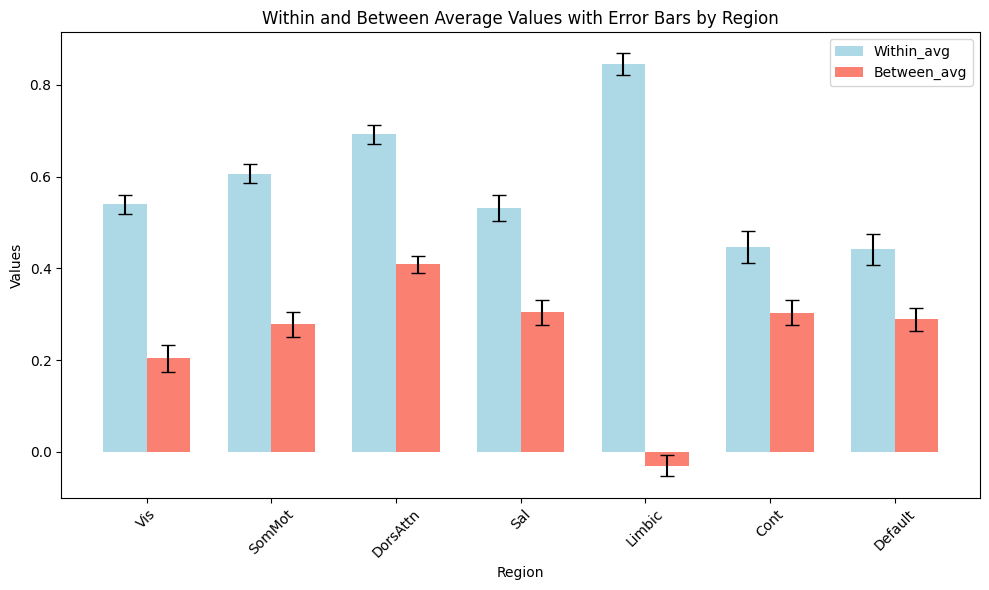

In [79]:
# Make a bar plot comparing within vs between values.
# Extract values
df = cestdf
regions = df.columns
within_avg = df.loc['Within_avg']
within_sd = df.loc['Within_sd']
between_avg = df.loc['Between_avg']
between_sd = df.loc['Between_sd']

# Set positions and width for bars
n = 85 


x = np.arange(len(regions))
width = 0.35

within_se = within_sd / np.sqrt(n)
between_se = between_sd / np.sqrt(n)

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot within and between averages with error bars
#ax.bar(x - width/2, within_avg, width, yerr=within_sd, label='Within_avg', capsize=5, color='lightblue')
#ax.bar(x + width/2, between_avg, width, yerr=between_sd, label='Between_avg', capsize=5,color='salmon')
ax.bar(x - width/2, within_avg, width, yerr=within_se, label='Within_avg', capsize=5, color='lightblue')
ax.bar(x + width/2, between_avg, width, yerr=between_se, label='Between_avg', capsize=5, color='salmon')


# Set labels and title
ax.set_xlabel('Region')
ax.set_ylabel('Values')
ax.set_title('Within and Between Average Values with Error Bars by Region')
ax.set_xticks(x)
ax.set_xticklabels(regions)
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### NMAP correlations

In [7]:
# Read in nmap data 
nmapsdf = pd.read_csv("receptor_data_scale1000_17.csv", sep=',', header=None)
#nmapsdf.columns = nmaps 

# Trim cestmat and keep only the columns with avg values.
cestNZMeans = keep(grp_df, ["NZMean"])
cestavgs = cestNZMeans.mean(axis=0)
# Make new df to store avg nmap values and average CEST values.
glunmaps = nmapsdf.copy()
glunmaps.index = range(1,1001)
glunmaps["CESTavg"] = np.nan
# Add values to new df
for i in range(501,1001):
    cestparcel = f'NZMean_{i}'
    if cestparcel in cestavgs.index:
        #print(cestparcel)
        #print(cestavgs[cestparcel])
        glunmaps.loc[i,"CESTavg"] = cestavgs[cestparcel]
glunmaps = glunmaps.dropna(subset=["CESTavg"])

In [8]:
sorted_df = glunmaps.sort_values(by="CESTavg", ascending=False)  # Use ascending=True if you want to sort in ascending order

print(sorted_df)

            0         1         2    CESTavg
518  5.827461 -1.884991 -0.392477  10.641749
504  6.406018 -0.633749  1.279621  10.161161
532  5.646722 -0.540665  0.404331   9.893395
502  7.192964 -0.377612  2.481264   9.821854
563  4.545387 -0.732697 -0.808888   9.638502
..        ...       ...       ...        ...
946  5.544856 -1.208752 -0.942742   6.847678
938  7.172033  1.548303  1.286203   6.711090
908  4.580144 -3.234550 -1.256276   6.696995
939  6.802049 -0.355992  0.003789   6.460084
811  7.013567  0.647284  0.794431   6.218522

[102 rows x 4 columns]


In [9]:
# Loop through nmaps and make correlation plots
# @Maggie, add color by SA axis value.
for nmap in nmaps:
    formula = f'CESTavg ~ {nmap}'
    rval, pval = pearsonr(glunmaps[nmap],glunmaps["CESTavg"])
    print(nmap)
    print("r=" + str(rval)," p=" + str(pval))

for nmap in nmaps:
    plot = sns.lmplot(x=nmap, y='CESTavg', data=glunmaps)
    plt.xlabel(nmap)
    plt.ylabel("CESTavg")
    #slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', network], graph_df.loc[graph_df['dx_pscat'] == 'PSY', cestcol])
    #plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    # Generate and add slope, r2 and p for subset 2
    #slope, intercept, r_value, p_value, std_err = linregress(graph_df[network], graph_df[cestcol])
    #plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    
    plt.title('Linear Regression between ' + nmap + ' and CEST')
    plt.show() 





KeyError: 'NMDA'

In [111]:
import statsmodels.api as sm

x=glunmaps[nmaps]
y=glunmaps["CESTavg"]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())


KeyError: "None of [Index(['NMDA', 'mGluR5', 'GABA', 'D2'], dtype='object')] are in the [columns]"

### Neuromaps correlations by diagnosis

In [10]:
from itertools import repeat 
# Read in nmap data 
nmapsdf = pd.read_csv("/Users/pecsok/projects/Neuromaps/pecsok_pfns/neuromaps/results/receptor_data_scale1000_17.csv", sep=',')
#nmapsdf.columns = nmaps 
print(nmapsdf)
nmapsdf.index = range(1,1001)


# Trim cestmat and keep only the columns with avg values.
df = keep(grp_df, (["NZMean", "hstatus"]))
NC_cestNZMeans = df.loc[:, (df.columns.str.contains("NZMean"))]
NCcestavgs = df[df["hstatus"] == "NC"].filter(like="NZMean").mean(axis=0)
PScestavgs = df[df["hstatus"] != "NC"].filter(like="NZMean").mean(axis=0)
parcels = df.filter(like="NZMean").columns.tolist()


cestdf = pd.DataFrame(
    zip(
        list(repeat("HC", len(NCcestavgs))) + list(repeat("Psy", len(PScestavgs))),  # Repeat "NC" and "PS"
        parcels + parcels,  # Parcel names repeated for both NC and PS
        np.concatenate([NCcestavgs.values, PScestavgs.values]),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(PScestavgs))),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(PScestavgs))),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(PScestavgs)))
    ),  # Concatenate the values for NC and PS
        #np.concatenate([nmap_NC_parcel_values, nmap_PS_parcel_values])  # Concatenate nmap parcel values  
    columns=["hstatus", "parcel", "CESTavg",'mGluR5', 'NMDA', 'GABA']
)

for nmap in nmaps:
    for i in range(501,1001):
        parcel = "NZMean_" + str(i) 
        if parcel in cestdf["parcel"].values:
            cestdf.loc[cestdf["parcel"] == parcel, nmap] = nmapsdf.loc[i, nmap]          

cestdf

         NMDA    mGluR5      GABA        D2
0    0.222071 -1.676590  0.454865 -1.793413
1   -0.498181 -1.582004  0.778041 -1.725353
2    0.901576 -0.612121  2.141349 -1.079382
3   -1.250976 -2.019832 -0.681790 -1.734788
4    0.924391 -0.341650  0.853886  0.268522
..        ...       ...       ...       ...
995  0.906115  0.748027  0.435516  0.148707
996 -0.093347  0.810461 -0.015695  0.217057
997  0.859066  0.746511  0.069180  0.635338
998  0.825170  1.057345  0.635444  0.371140
999  0.219509  1.022109  0.470702  0.717365

[1000 rows x 4 columns]


hstatus      parcel    CESTavg    mGluR5      NMDA      GABA        D2
0        HC  NZMean_502   9.828479 -0.377612  0.946837  2.481264 -1.023769
1        HC  NZMean_504   9.437898 -0.633749   0.11543  1.279621 -1.001126
2        HC  NZMean_518  10.497883 -1.884991 -0.495814 -0.392477 -1.492911
3        HC  NZMean_521   9.542822 -0.751941  0.605485  2.199508 -1.002266
4        HC  NZMean_532   9.874344 -0.540665 -0.686764  0.404331 -0.901871
..      ...         ...        ...       ...       ...       ...       ...
199     Psy  NZMean_959   7.011228 -1.215862 -2.061078 -1.375083 -1.214219
200     Psy  NZMean_961   7.109773 -0.445693 -0.275643 -0.940862 -0.375608
201     Psy  NZMean_962   7.451376 -0.837716 -0.825567 -0.653351 -0.560040
202     Psy  NZMean_973   8.226691  0.314567   1.10268  0.781787 -0.861531
203     Psy  NZMean_974   8.539871  0.207029  1.159294  0.682662 -0.736926

[204 rows x 7 columns]

In [11]:
# Trim cestmat and keep only the columns with avg values.
df = keep(grp_df, (["NZMean", "hstatus"]))
#NC_cestNZMeans = df.loc[:, (df.columns.str.contains("NZMean"))]
NCcestavgs = df[df["hstatus"] == "NC"].filter(like="NZMean").mean(axis=0)
PScestavgs = df[df["hstatus"] != "NC"].filter(like="NZMean").mean(axis=0)
parcels = df.filter(like="NZMean").columns.tolist()
cestavgs = df.filter(like="NZMean").mean(axis=0)
print(cestavgs)

cestdf = pd.DataFrame(
    zip(
        list(repeat("HC", len(NCcestavgs))) + list(repeat("Psy", len(PScestavgs))),  # Repeat "NC" and "PS"
        parcels + parcels,  # Parcel names repeated for both NC and PS
        np.concatenate([NCcestavgs.values, PScestavgs.values]),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(PScestavgs))),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(PScestavgs))),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(PScestavgs)))
    ),  # Concatenate the values for NC and PS
        #np.concatenate([nmap_NC_parcel_values, nmap_PS_parcel_values])  # Concatenate nmap parcel values  
    columns=["hstatus", "parcel", "CESTavg",'mGluR5', 'NMDA', 'GABA']
)

for nmap in nmaps:
    for i in range(501,1001):
        parcel = "NZMean_" + str(i) 
        if parcel in cestdf["parcel"].values:
            cestdf.loc[cestdf["parcel"] == parcel, nmap] = nmapsdf.loc[i, nmap]          

cestdf

NZMean_502     9.821854
NZMean_504    10.161161
NZMean_518    10.641749
NZMean_521     9.338252
NZMean_532     9.893395
                ...    
NZMean_959     7.015993
NZMean_961     7.220519
NZMean_962     7.610487
NZMean_973     8.390245
NZMean_974     8.729365
Length: 102, dtype: float64


hstatus      parcel    CESTavg    mGluR5      NMDA      GABA        D2
0        HC  NZMean_502   9.828479 -0.377612  0.946837  2.481264 -1.023769
1        HC  NZMean_504   9.437898 -0.633749   0.11543  1.279621 -1.001126
2        HC  NZMean_518  10.497883 -1.884991 -0.495814 -0.392477 -1.492911
3        HC  NZMean_521   9.542822 -0.751941  0.605485  2.199508 -1.002266
4        HC  NZMean_532   9.874344 -0.540665 -0.686764  0.404331 -0.901871
..      ...         ...        ...       ...       ...       ...       ...
199     Psy  NZMean_959   7.011228 -1.215862 -2.061078 -1.375083 -1.214219
200     Psy  NZMean_961   7.109773 -0.445693 -0.275643 -0.940862 -0.375608
201     Psy  NZMean_962   7.451376 -0.837716 -0.825567 -0.653351 -0.560040
202     Psy  NZMean_973   8.226691  0.314567   1.10268  0.781787 -0.861531
203     Psy  NZMean_974   8.539871  0.207029  1.159294  0.682662 -0.736926

[204 rows x 7 columns]

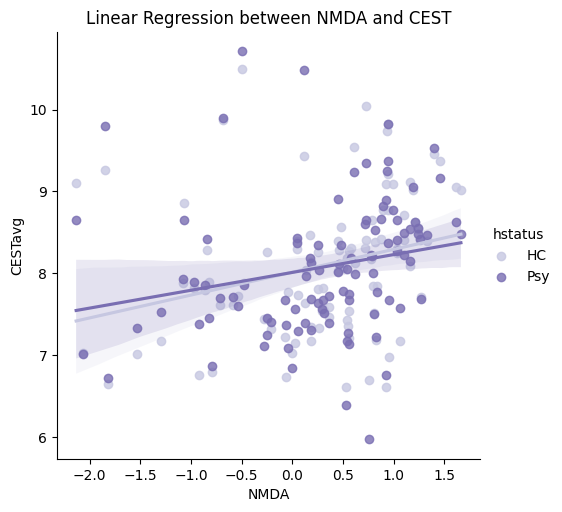

NMDA  All participants Pearson
r=0.24877917646340852  p=0.00033319888310494815


NameError: name 'graphdf' is not defined

In [12]:
# Loop through nmaps and make correlation plots
#print(cestdf[CESTavg].max())
from scipy.stats import spearmanr
nmap_palette = {
    "NMDA": "Purples",   # Replace with actual nmap names and desired palettes
    "mGluR5": "Reds",
    "GABA": "Greens",
    "D2": "Oranges"
    # Add more mappings as needed
}

for nmap in nmaps:
    cestdf[nmap] = pd.to_numeric(cestdf[nmap], errors='coerce')
    cestdf['CESTavg'] = pd.to_numeric(cestdf['CESTavg'], errors='coerce')
    plot_data = cestdf.dropna(subset=[nmap, 'CESTavg'])
    palette = nmap_palette.get(nmap) # Default to "Set1" if nmap not in dictionary
    plot = sns.lmplot(x=nmap, y='CESTavg', hue='hstatus', data=plot_data, palette=palette)
    plt.xlabel(nmap)
    plt.ylabel("CESTavg")
    plt.title('Linear Regression between ' + nmap + ' and CEST')
    plt.show() 
    rval, pval = pearsonr(cestdf[nmap],cestdf["CESTavg"])
    print(nmap + "  All participants Pearson")
    print("r=" + str(rval)," p=" + str(pval))
    rval, pval = spearmanr(graphdf[nmap],graphdf["CESTavg"])
    print(nmap + "  All participants Spearman")
    print("r=" + str(rval)," p=" + str(pval))

    for group in ["Psy","HC"]:
        graphdf = cestdf[cestdf["hstatus"]==group]
        formula = f'CESTavg ~ {nmap}'
        rval, pval = pearsonr(graphdf[nmap],graphdf["CESTavg"])
        print(nmap + "  " + group)
        print("r=" + str(rval)," p=" + str(pval))


In [25]:
# Pearson correlation value per group
for nmap in nmaps:
    for group in ["Psy","HC"]:
        graphdf = cestdf[cestdf["hstatus"]==group]
        formula = f'CESTavg ~ {nmap}'
        rval, pval = pearsonr(graphdf[nmap],graphdf["CESTavg"])
        print(nmap)
        print("r=" + str(rval)," p=" + str(pval))

for nmap in nmaps:
        graphdf = cestdf[cestdf["hstatus"]==group]
        formula = f'CESTavg ~ {nmap}'
        rval, pval = pearsonr(graphdf[nmap],graphdf["CESTavg"])
        print(nmap)
        print("r=" + str(rval)," p=" + str(pval))


NMDA
r=0.21965532281092784  p=0.026538836382986025
NMDA
r=0.2775414445755163  p=0.004739990389552991
mGluR5
r=0.013108880566002835  p=0.8959595330576334
mGluR5
r=0.0405187122345066  p=0.6859615285340444
GABA
r=0.48728751663566683  p=2.059481912112224e-07
GABA
r=0.5371755174214814  p=5.858523314928414e-09
D2
r=-0.3555216183846399  p=0.00024551175051368946
D2
r=-0.32249826341911525  p=0.0009473247239280081


In [26]:
from scipy.stats import spearmanr

for nmap in nmaps:
    for group in ["Psy","HC"]:
        graphdf = cestdf[cestdf["hstatus"]==group]
        formula = f'CESTavg ~ {nmap}'
        rval, pval = spearmanr(graphdf[nmap],graphdf["CESTavg"])
        print(nmap)
        print("r=" + str(rval)," p=" + str(pval))


NMDA
r=0.39639583604277046  p=3.718004675496111e-05
NMDA
r=0.3904812525798554  p=4.962987556916636e-05
mGluR5
r=0.0877631452465635  p=0.3804136521693289
mGluR5
r=0.07638633652057382  p=0.44542041916585473
GABA
r=0.5102430859876393  p=4.296189388785467e-08
GABA
r=0.5184760052247372  p=2.3796386519907378e-08
D2
r=-0.3085704915437289  p=0.0016029211309696594
D2
r=-0.30030364544164295  p=0.002164728991193338


/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/4162567680.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/4162567680.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


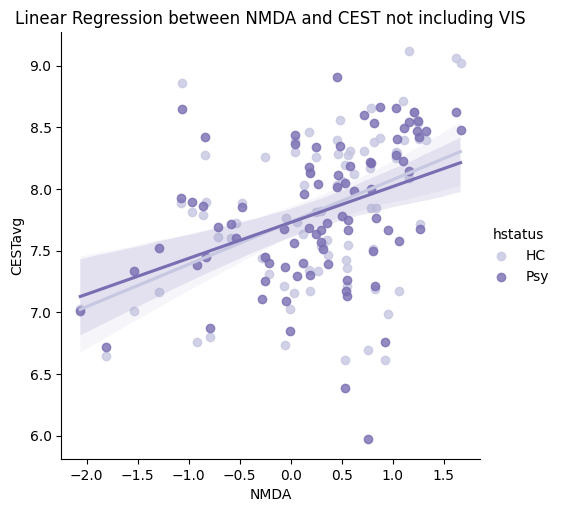

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/4162567680.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/4162567680.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


NMDA
r=0.4147441596198923  p=2.2790273851189843e-08


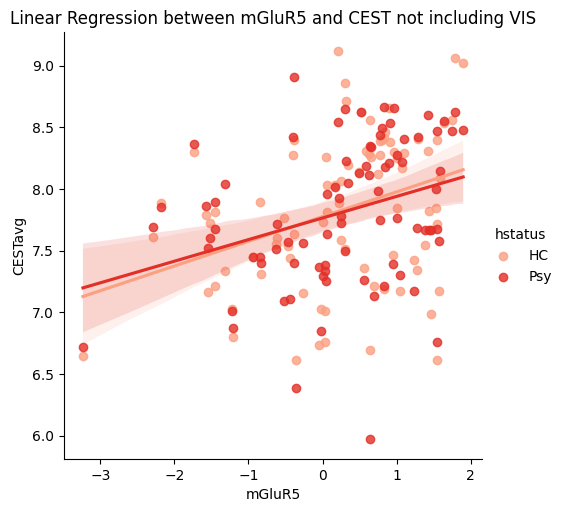

mGluR5
r=0.3366689977741987  p=8.115673592469759e-06


/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/4162567680.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/4162567680.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


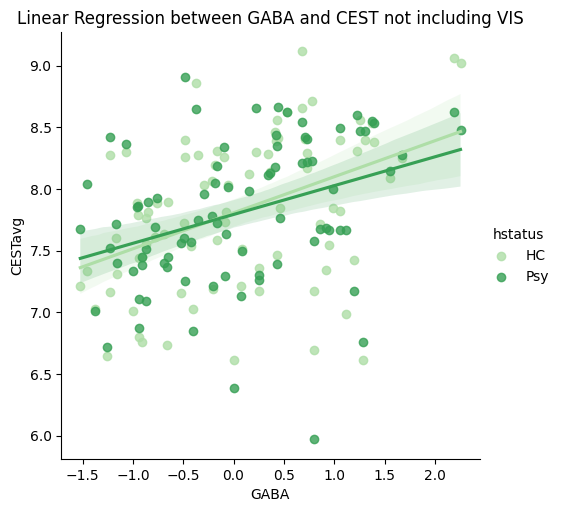

GABA
r=0.39411343444862246  p=1.2524302539381843e-07


/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/4162567680.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/4162567680.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


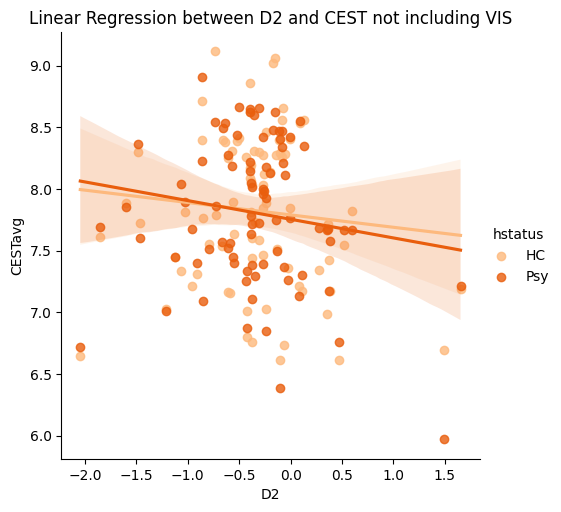

D2
r=-0.12239912530973181  p=0.1139745231950715


In [13]:
# Excluding visual network

vis = [str(x) for x in range(500,569)]
network_dict = {
    'VIS': vis
}

for nmap in nmaps:
    for network_name, parcel_range in network_dict.items():
        
        graphdf = cestdf[~cestdf['parcel'].str.extract('(\d+)')[0].isin(parcel_range)]
        #print(graphdf)
        #cestdf[cestdf['parcel'].str.extract('(\d+)').astype(float).between(500, 510)]
        graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
        graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'
        plot_data = graphdf.dropna(subset=[nmap, 'CESTavg'])
        palette = nmap_palette.get(nmap) # Default to "Set1" if nmap not in dictionary
        plot = sns.lmplot(x=nmap, y='CESTavg', hue='hstatus', data=plot_data, palette=palette)
        plt.xlabel(nmap)
        plt.ylabel("CESTavg")
        plt.title('Linear Regression between ' + nmap + ' and CEST not including ' + network_name)
        plt.show() 

        #for nmap in nmaps:
        #for group in ["Psy","HC"]:
        #graphdf = cestdf[cestdf["hstatus"]==group]
        rval, pval = pearsonr(graphdf[nmap],graphdf["CESTavg"])
        print(nmap)
        print("r=" + str(rval)," p=" + str(pval))


### GluCEST-nmap correlations within network.

        Unnamed: 0  Session dx_pscat hstatus  sex   age  race  ethnic  \
BBLID                                                                   
20303            0    12276  noDSMdx      NC  1.0  19.2   1.0     2.0   
90217            1    12064      pro     PRO  2.0  25.0   1.0     2.0   
88608            2  motive2      psy     PRO  1.0  25.4   2.0     2.0   
21874            3    12043      NaN     PSY  2.0  24.1   1.0     2.0   
94288            4    11948  noDSMdx      NC  1.0  22.7   1.0     2.0   
...            ...      ...      ...     ...  ...   ...   ...     ...   
135085          81  motive1      pro     PRO  2.0  18.9   1.0     2.0   
135277          82    12277      psy     PSY  2.0  30.2   2.0     2.0   
117397          83    10582    other    PROR  1.0  20.2   2.0     2.0   
87646           84    10496      NaN     NaN  NaN   NaN   NaN     NaN   
93242           85    12525    other    PROR  1.0  25.3   1.0     2.0   

        NZMean_502  NZcount_502  ...  reho_945  re

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


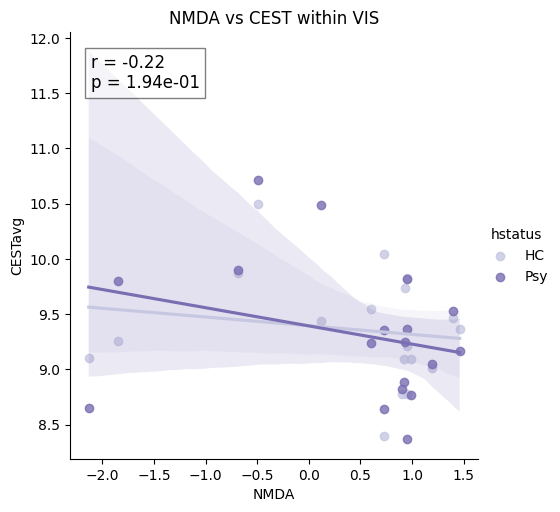

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


NMDA MN
r=0.5350297253499097  p=0.010296257163370978


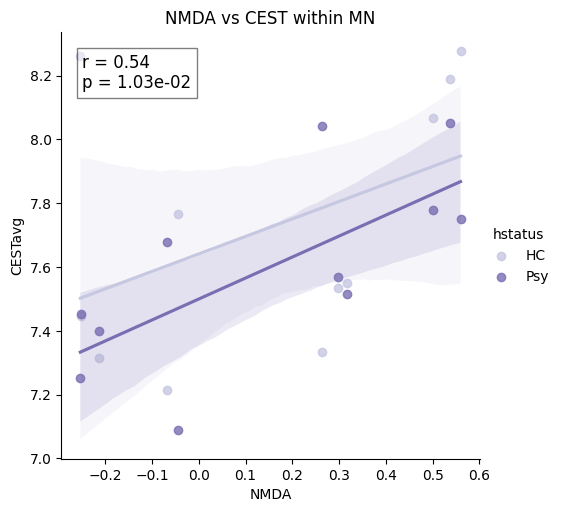

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


NMDA DA
r=-0.49362532997197694  p=0.21381159726260812


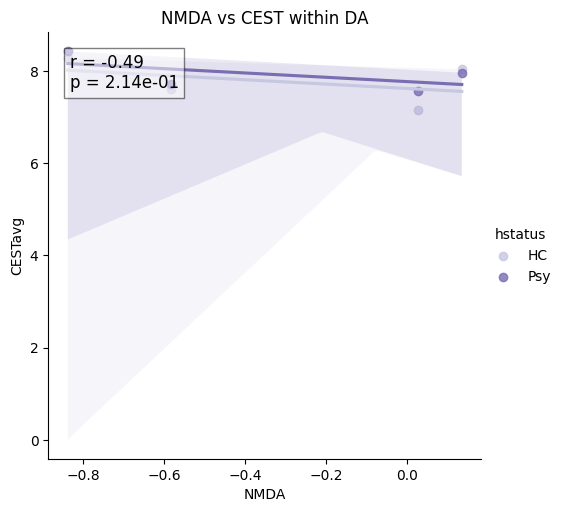

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


NMDA SN
r=0.362894582517017  p=0.02136646756651621


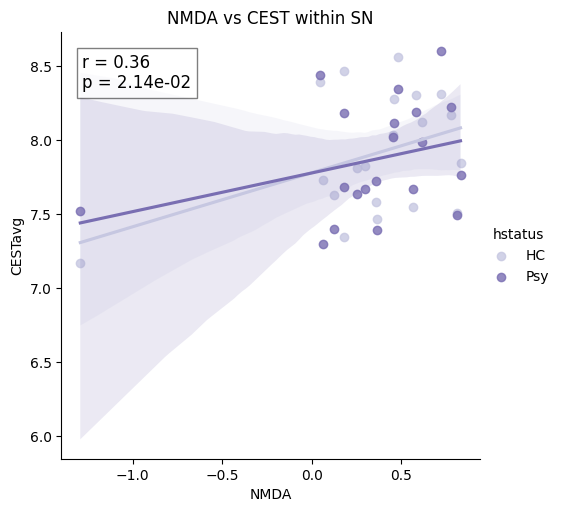

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


NMDA LIM
r=-0.7340449087960719  p=0.03814719641618752


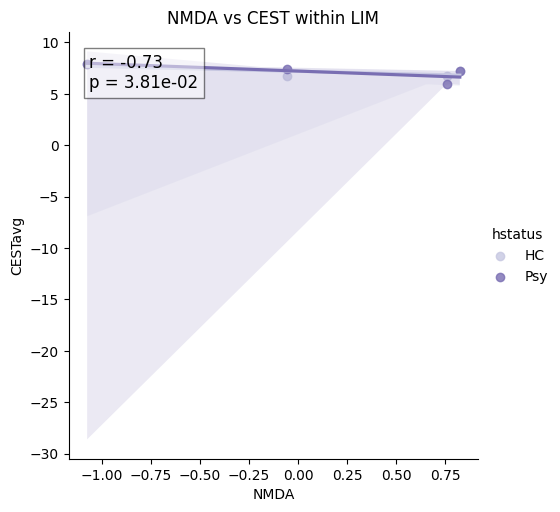

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


NMDA ECN
r=0.511732128101752  p=0.0014222340826967167


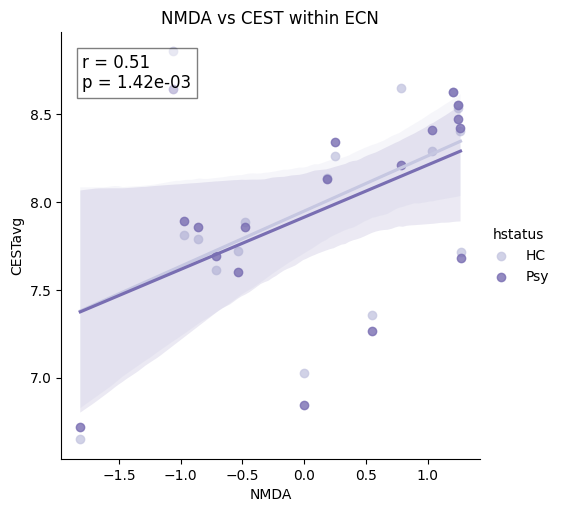

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


NMDA DMN
r=0.5672711245985498  p=7.72370352304766e-06


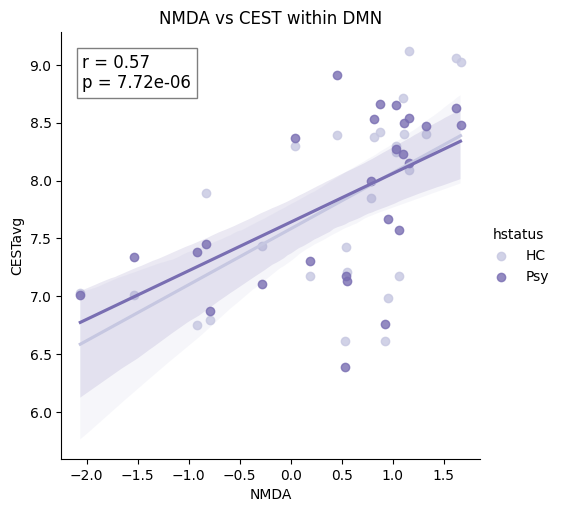

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


mGluR5 VIS
r=-0.6070756085422306  p=8.647517542646638e-05


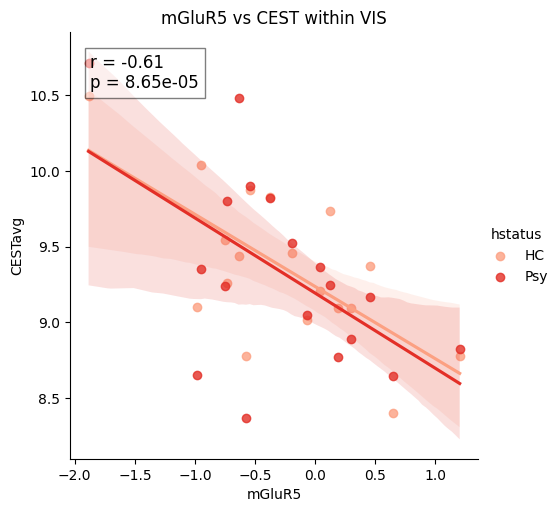

mGluR5 MN
r=0.5729372468158966  p=0.005318664396457953


/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


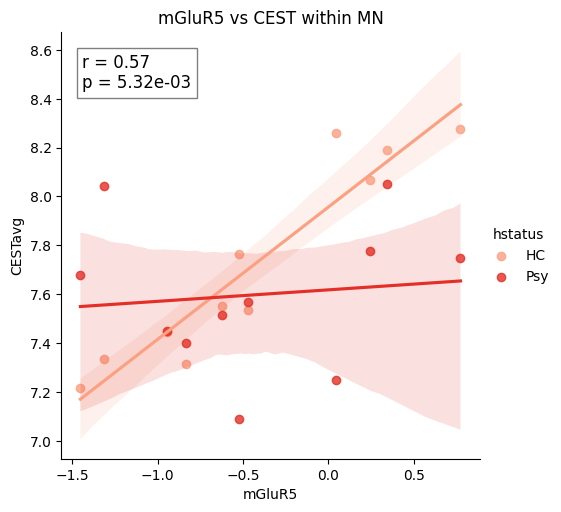

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


mGluR5 DA
r=0.11765812002779971  p=0.7814185598262591


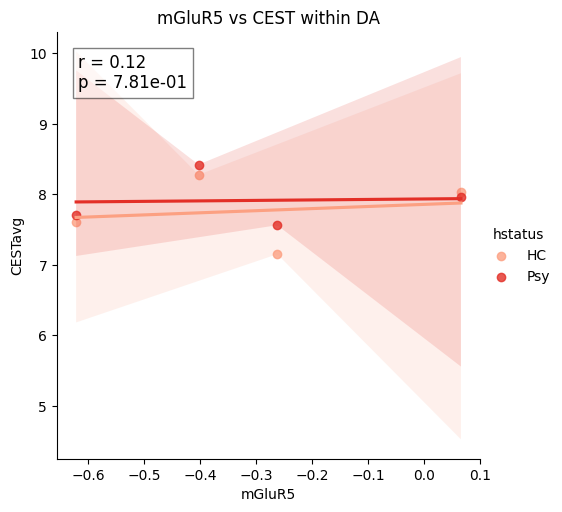

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


mGluR5 SN
r=0.3833376734623435  p=0.014620558084974476


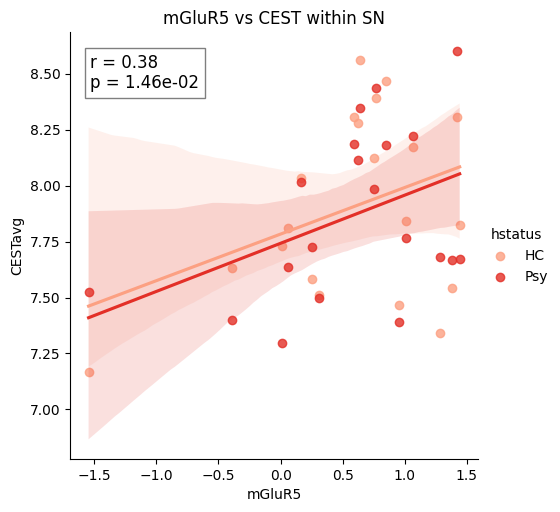

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


mGluR5 LIM
r=-0.31612187955659404  p=0.4455763823745823


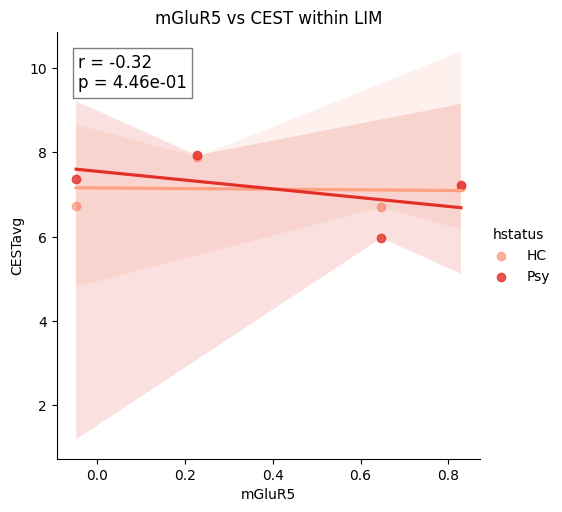

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


mGluR5 ECN
r=0.607010326573467  p=8.666803482636665e-05


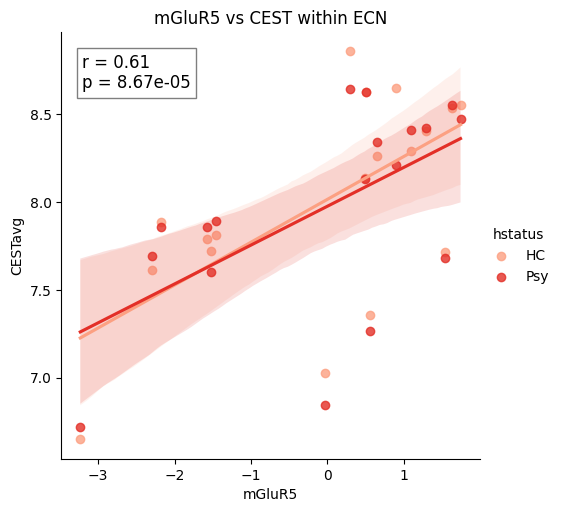

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


mGluR5 DMN
r=0.25671288065205466  p=0.06095203138067703


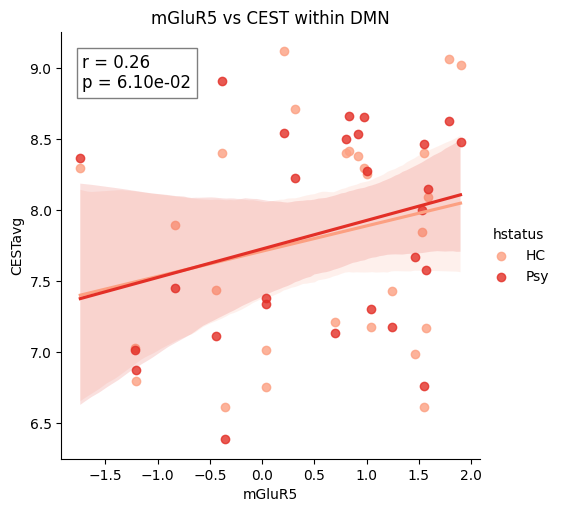

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


GABA VIS
r=-0.11982128944261639  p=0.4863852281992024


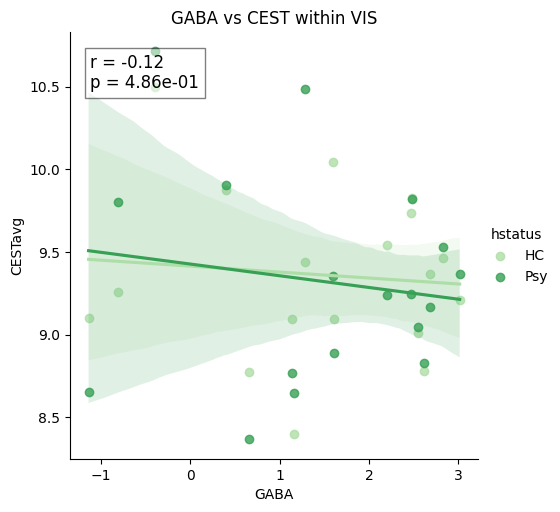

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


GABA MN
r=0.5059625465410346  p=0.016284379333636856


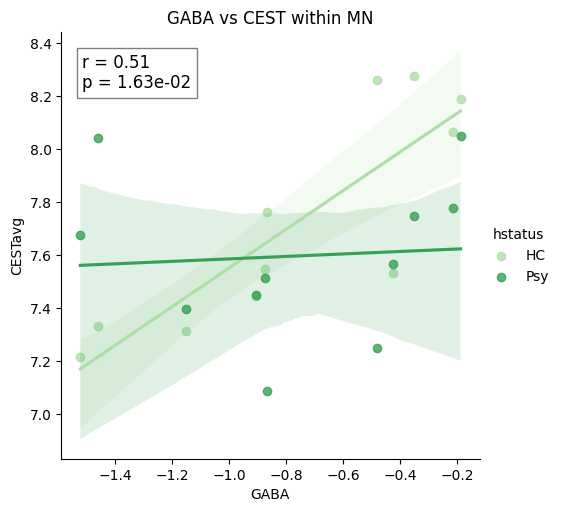

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


GABA DA
r=-0.32428782134300216  p=0.43324413654088983


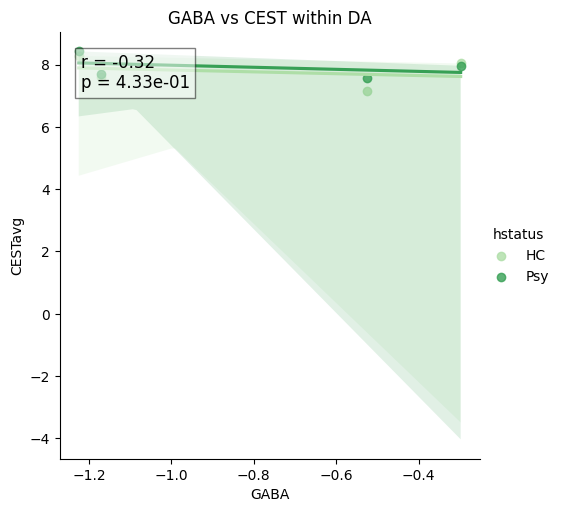

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


GABA SN
r=0.3624464217333595  p=0.021539448089048147


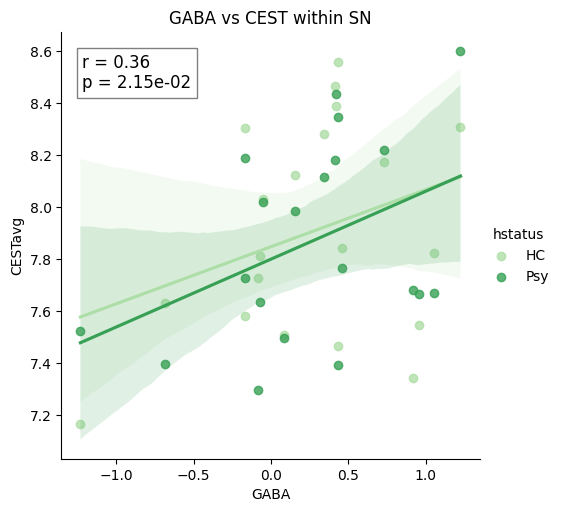

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


GABA LIM
r=-0.7953327026696546  p=0.018277795819296193


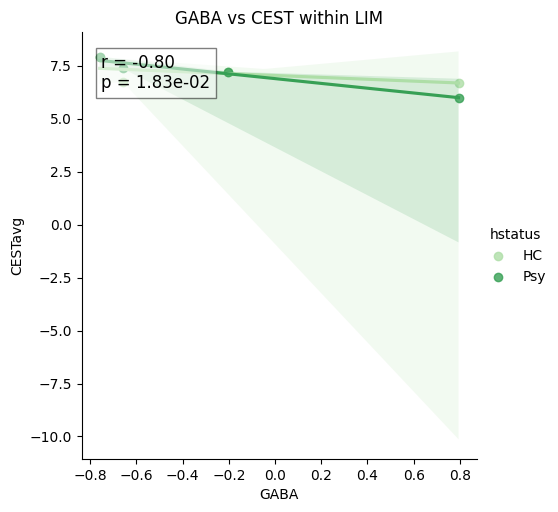

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


GABA ECN
r=0.586233595721388  p=0.0001719214230673508


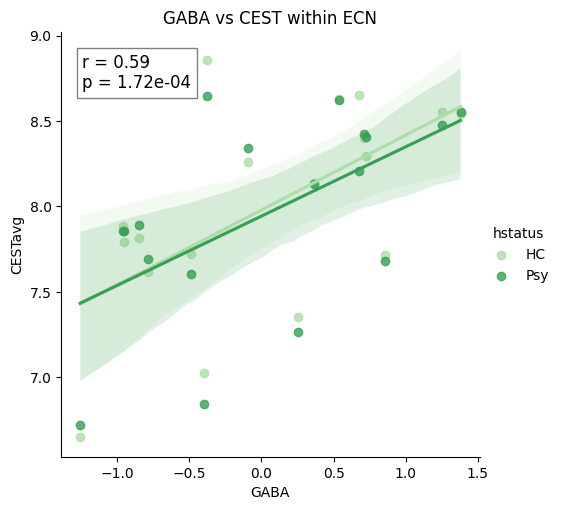

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


GABA DMN
r=0.4530647475875243  p=0.0005813159378476409


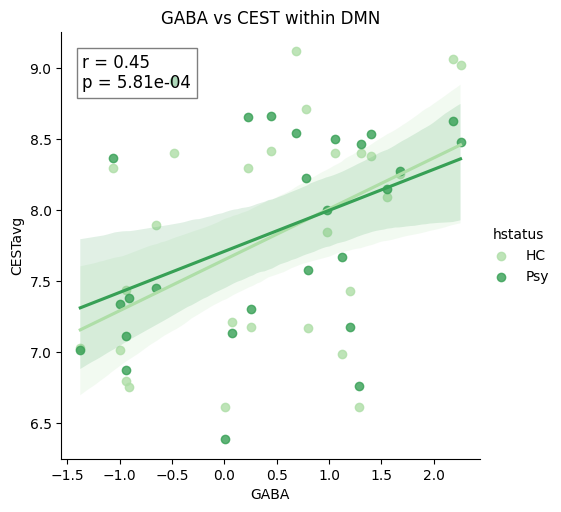

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


D2 VIS
r=-0.6235850124199968  p=4.844036123764555e-05


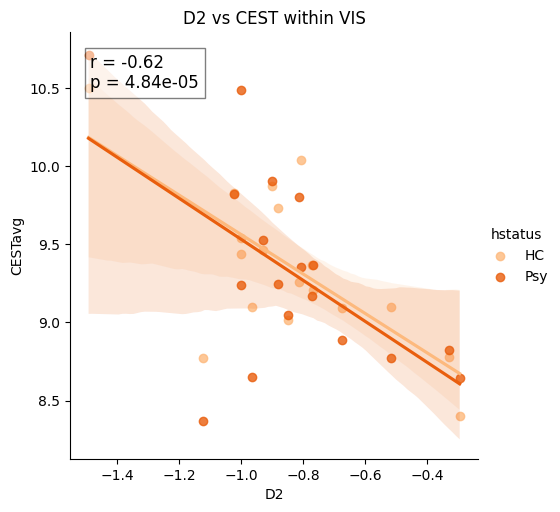

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


D2 MN
r=0.5897727394074265  p=0.003866116085275213


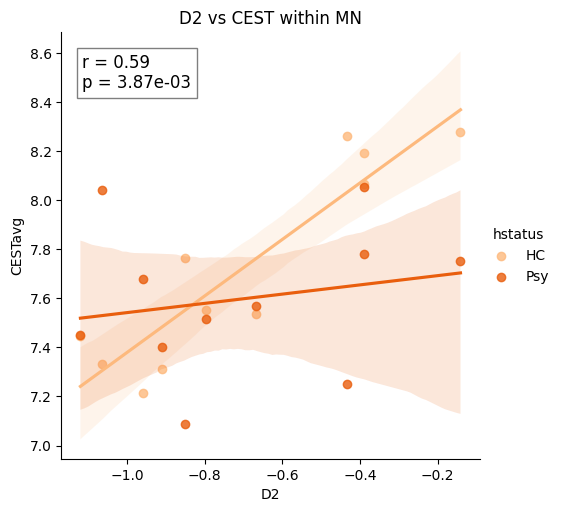

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


D2 DA
r=0.8605799787262979  p=0.006086411917974449


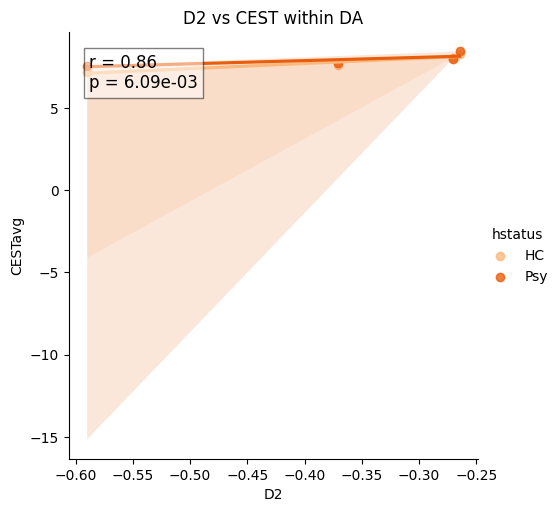

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


D2 SN
r=-0.11901941816563763  p=0.4644850873099352


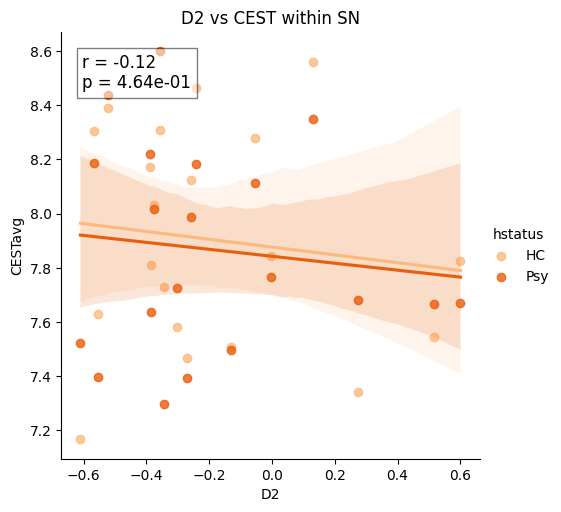

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


D2 LIM
r=-0.5851078923596644  p=0.12759676969262598


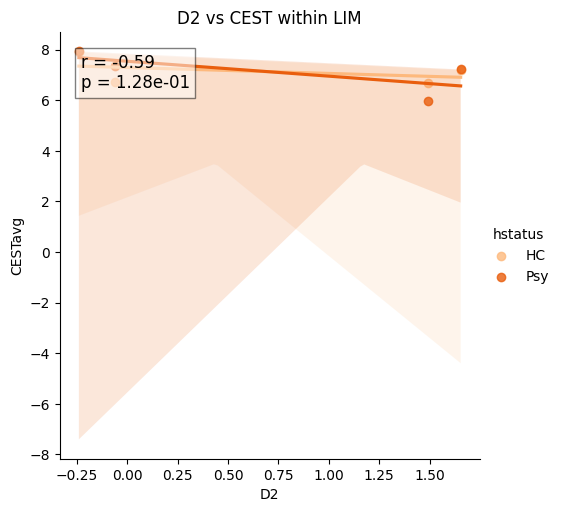

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


D2 ECN
r=0.48697910854945886  p=0.002595185110594464


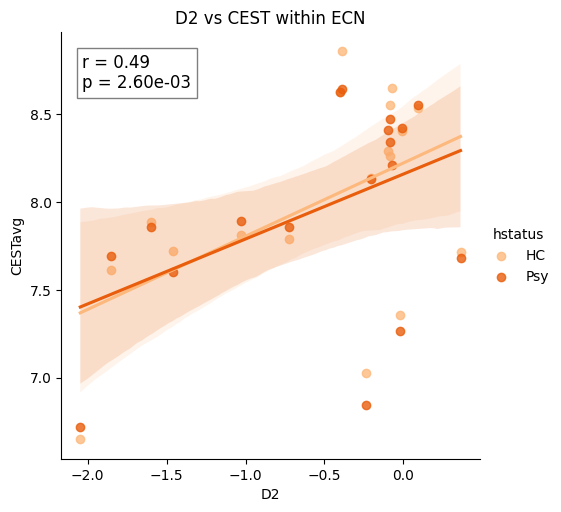

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_48243/1041609903.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


D2 DMN
r=-0.40280827101799127  p=0.002529208415752744


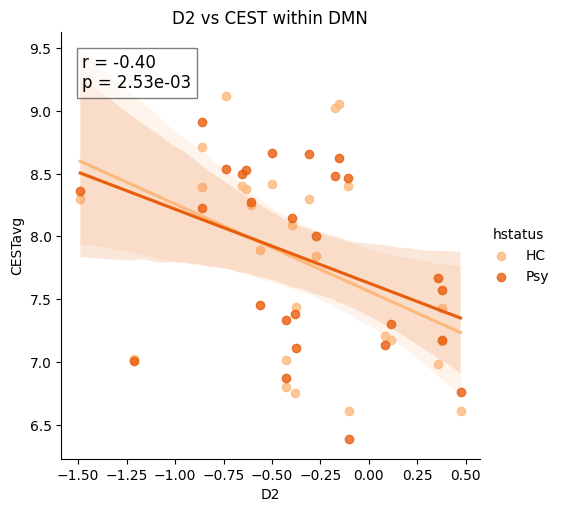

In [17]:

# Loop through nmaps and make correlation plots
#print(cestdf[CESTavg].max())


nmap_palette = {
    "NMDA": "Purples",   # Replace with actual nmap names and desired palettes
    "mGluR5": "Reds",
    "GABA": "Greens",
    "D2": "Oranges"
    # Add more mappings as needed
}



vis = [str(x) for x in range(500,569)]
mn = [str(x) for x in range(569,659)]
da = [str(x) for x in range(659,721)]
sn = [str(x) for x in range(721,798)]
lim = [str(x) for x in range(798,829)]
ecn = [str(x) for x in range(829,911)]
dmn = [str(x) for x in range(911,980)]

network_dict = {
    'VIS': vis,
    'MN': mn,
    'DA': da,
    'SN': sn,
    'LIM': lim,
    'ECN': ecn,
    'DMN': dmn
}



print(grp_df)
cestdata = grp_df.filter(like="NZ", axis=1).filter(like="fc", axis=1)

for nmap in nmaps:
    for network_name, parcel_range in network_dict.items():
        graphdf = cestdf[cestdf['parcel'].str.extract('(\d+)')[0].isin(parcel_range)]
        #print(graphdf)
        #cestdf[cestdf['parcel'].str.extract('(\d+)').astype(float).between(500, 510)]
        graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
        graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'
        plot_data = graphdf.dropna(subset=[nmap, 'CESTavg'])
        palette = nmap_palette.get(nmap) # Default to "Set1" if nmap not in dictionary
        plot = sns.lmplot(x=nmap, y='CESTavg', hue='hstatus', data=plot_data, palette=palette)
        plt.xlabel(nmap)
        plt.ylabel("CESTavg")
        plt.title(nmap + ' vs CEST within ' + network_name)

        
        rval, pval = pearsonr(graphdf[nmap],graphdf["CESTavg"])
        print(nmap, network_name)
        print("r=" + str(rval)," p=" + str(pval))
        plt.text(0.05, 0.95, f'r = {rval:.2f}\np = {pval:.2e}', 
                 transform=plt.gca().transAxes, 
                 fontsize=12, verticalalignment='top',
                 bbox=dict(facecolor='white', alpha=0.5))
        plt.show()

    hstatus      parcel    CESTavg    mGluR5      NMDA      GABA        D2
0        HC  NZMean_502   9.828479 -0.377612  0.946837  2.481264 -1.023769
1        HC  NZMean_504   9.437898 -0.633749   0.11543  1.279621 -1.001126
2        HC  NZMean_518  10.497883 -1.884991 -0.495814 -0.392477 -1.492911
3        HC  NZMean_521   9.542822 -0.751941  0.605485  2.199508 -1.002266
4        HC  NZMean_532   9.874344 -0.540665 -0.686764  0.404331 -0.901871
..      ...         ...        ...       ...       ...       ...       ...
199     Psy  NZMean_959   7.011228 -1.215862 -2.061078 -1.375083 -1.214219
200     Psy  NZMean_961   7.109773 -0.445693 -0.275643 -0.940862 -0.375608
201     Psy  NZMean_962   7.451376 -0.837716 -0.825567 -0.653351 -0.560040
202     Psy  NZMean_973   8.226691  0.314567   1.10268  0.781787 -0.861531
203     Psy  NZMean_974   8.539871  0.207029  1.159294  0.682662 -0.736926

[204 rows x 7 columns]


/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


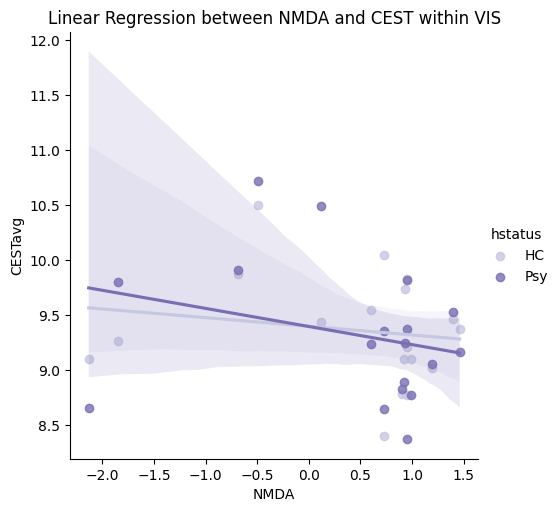

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


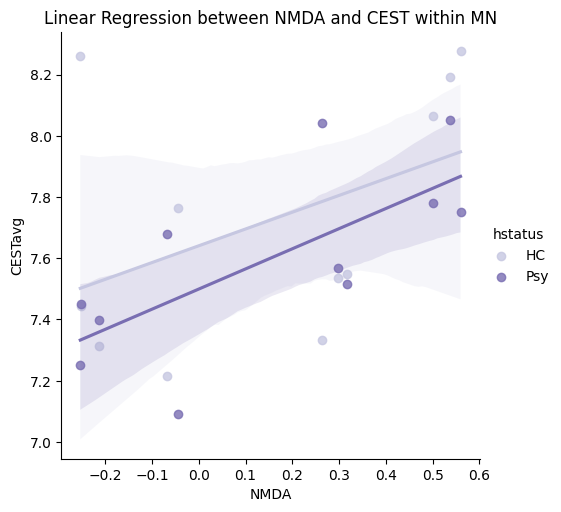

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


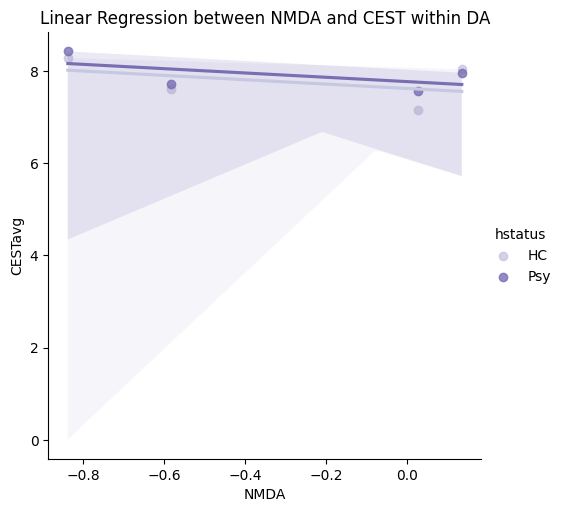

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


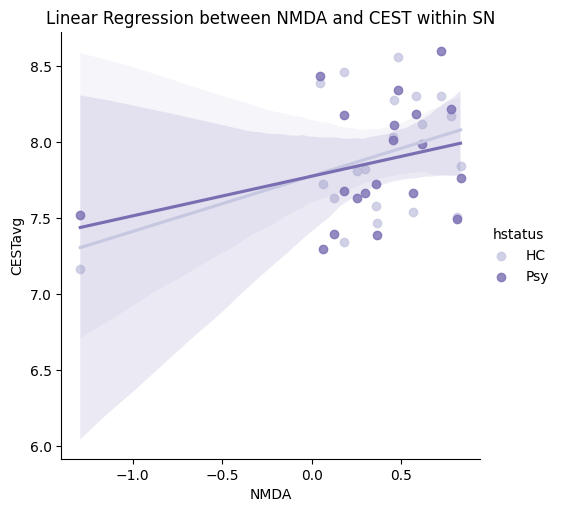

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


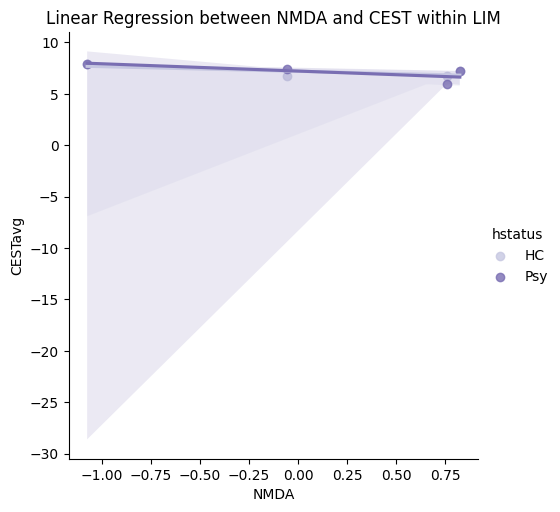

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


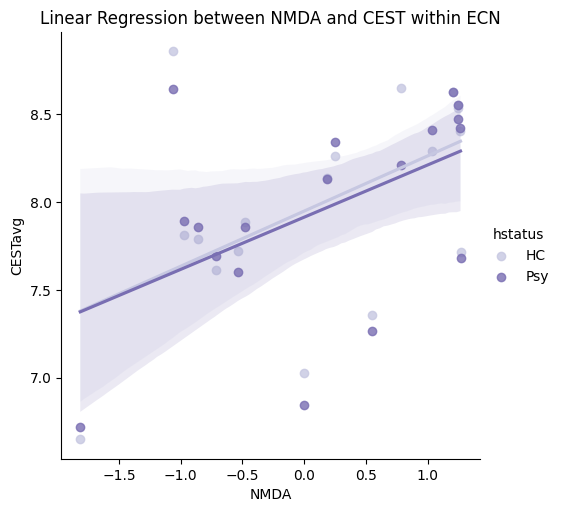

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


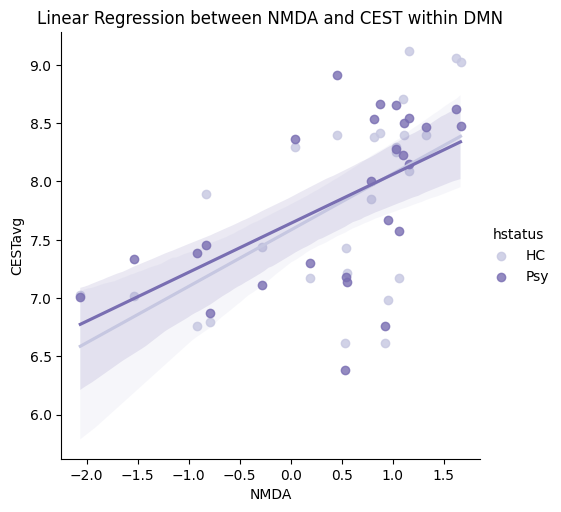

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


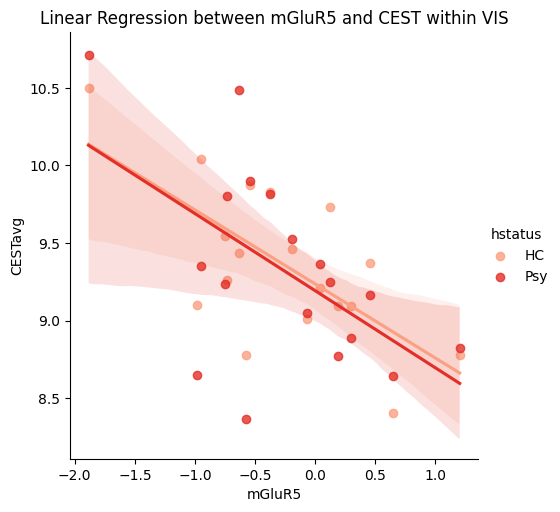

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


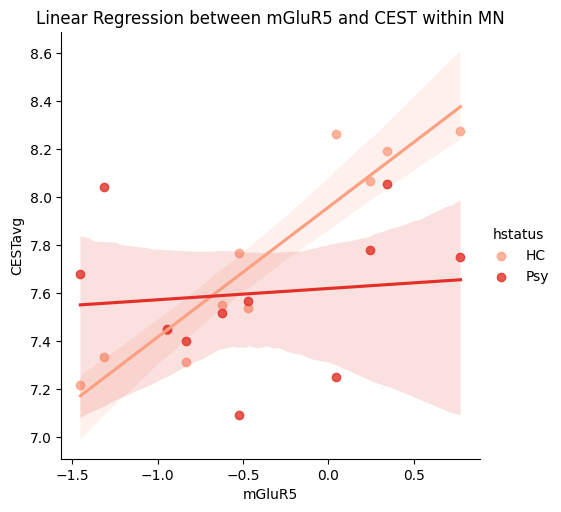

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


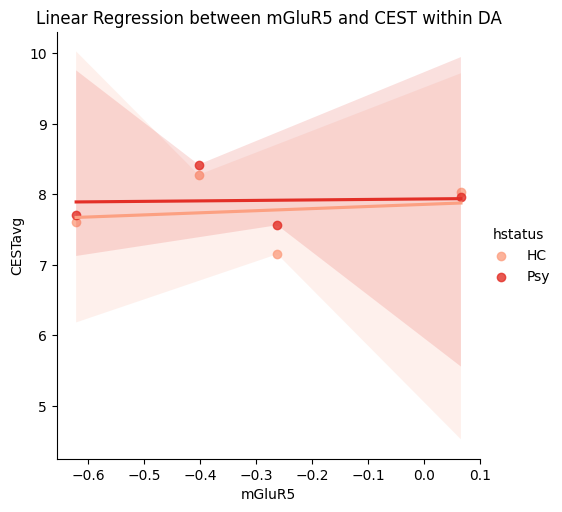

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


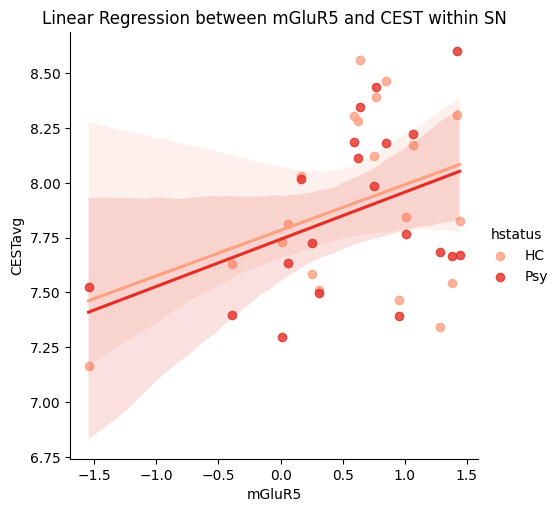

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


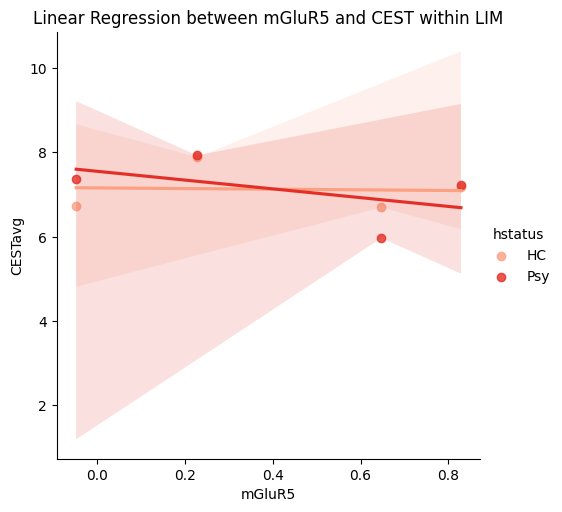

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


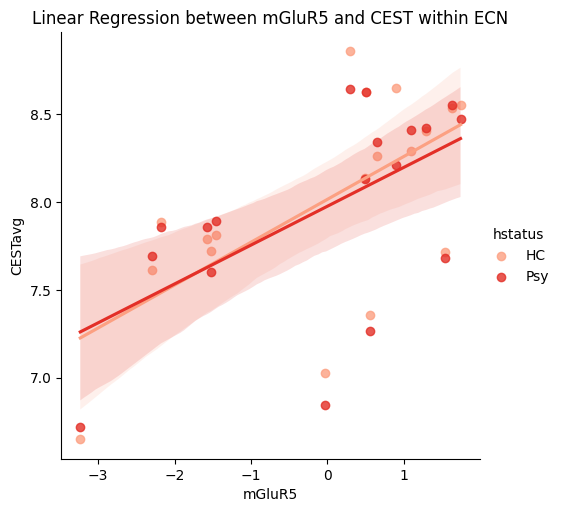

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


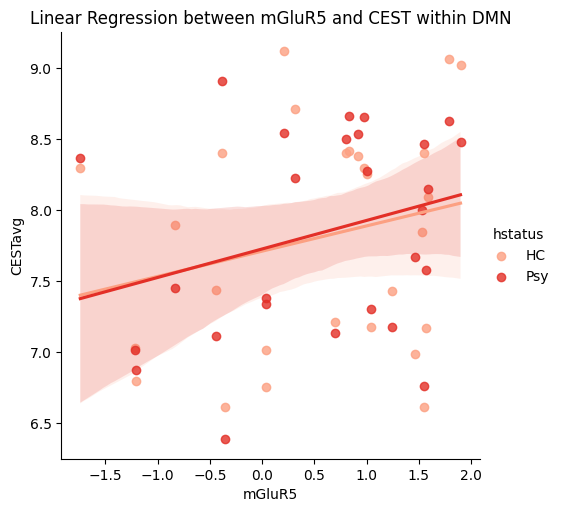

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


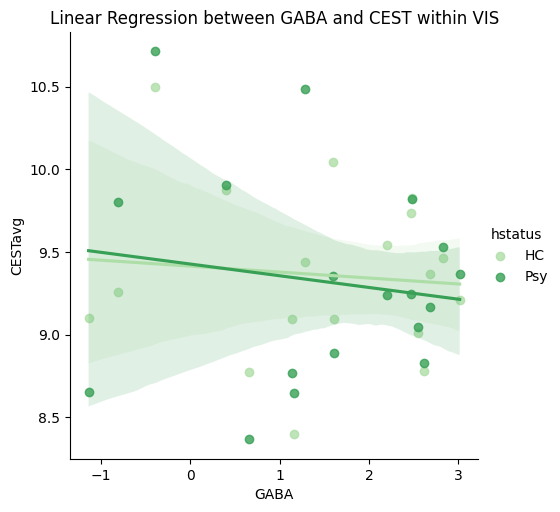

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


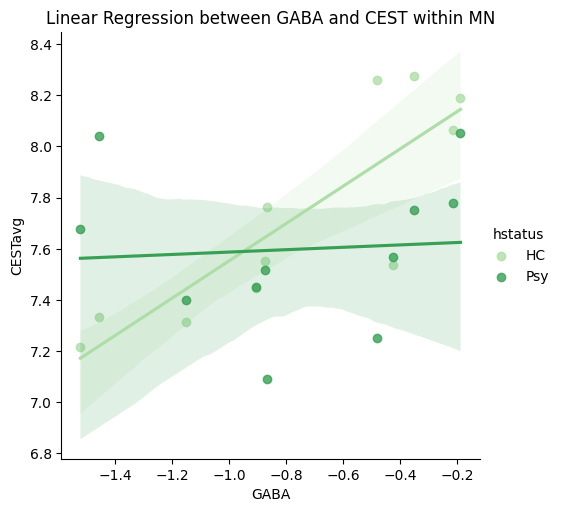

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


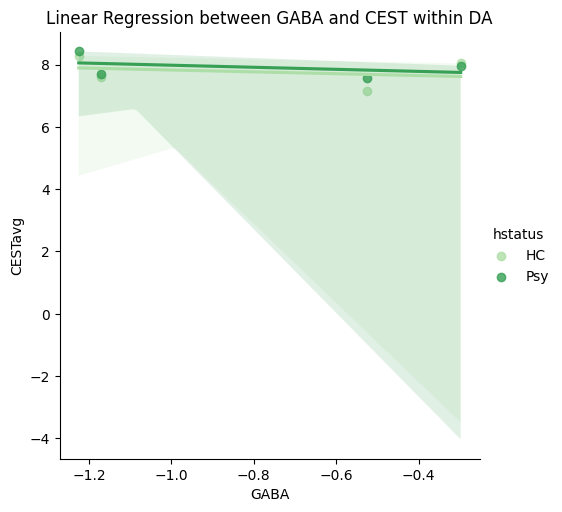

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


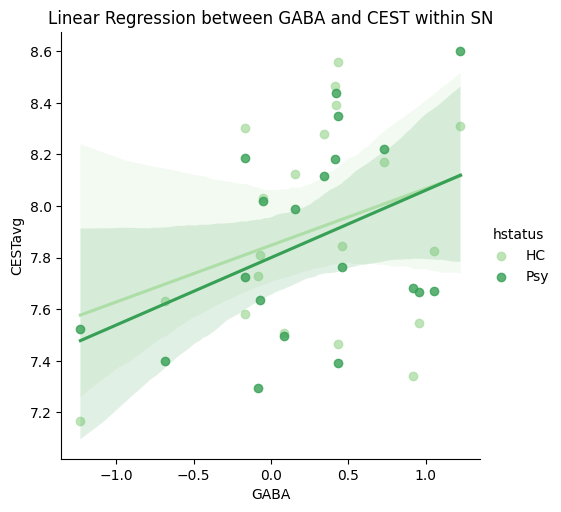

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


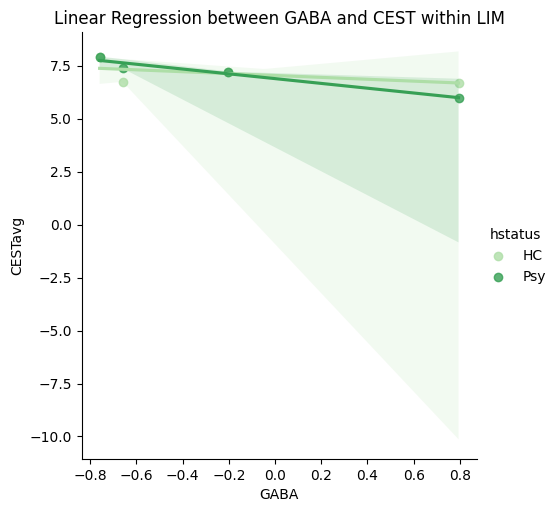

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


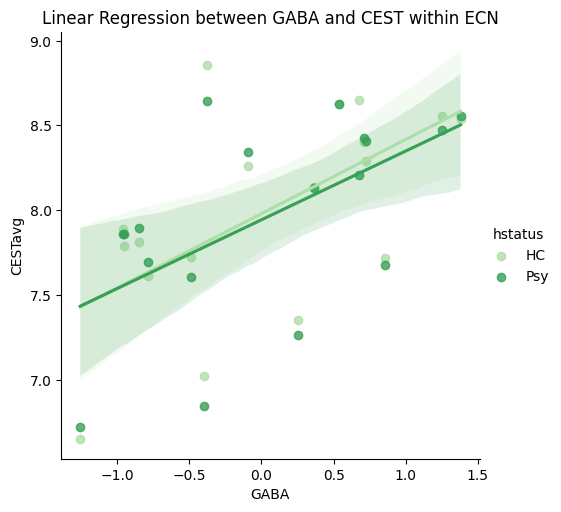

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


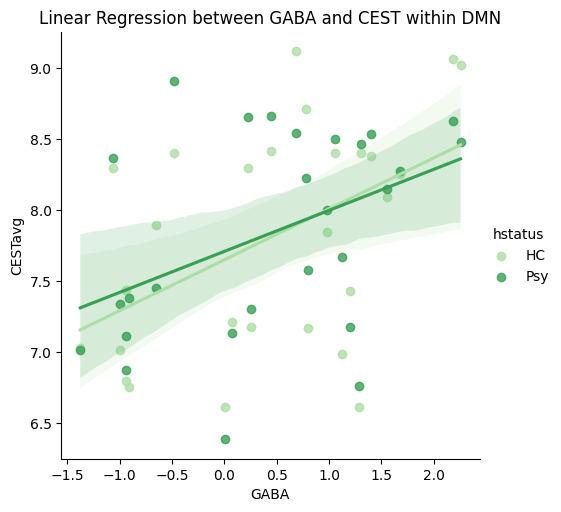

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


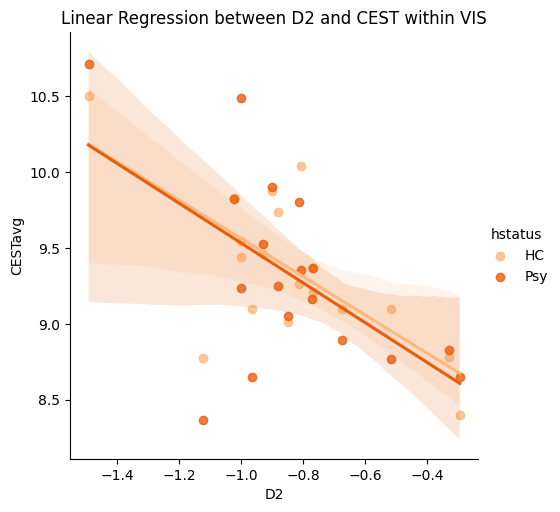

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


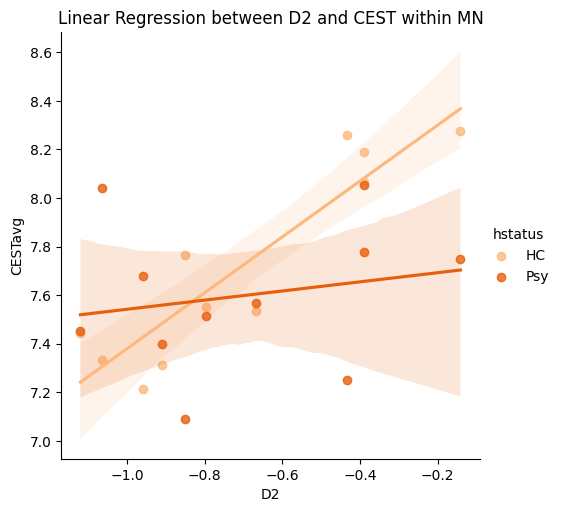

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


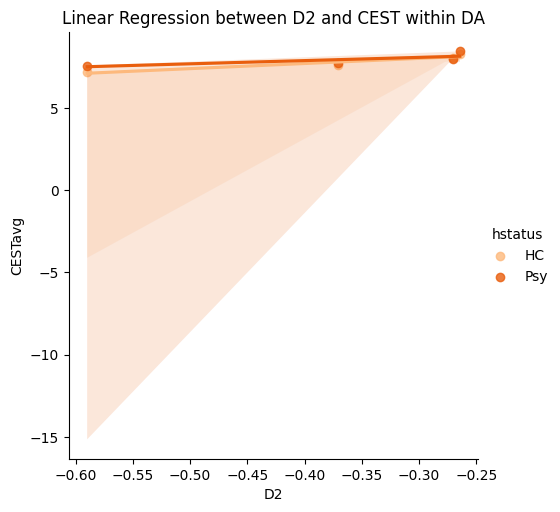

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


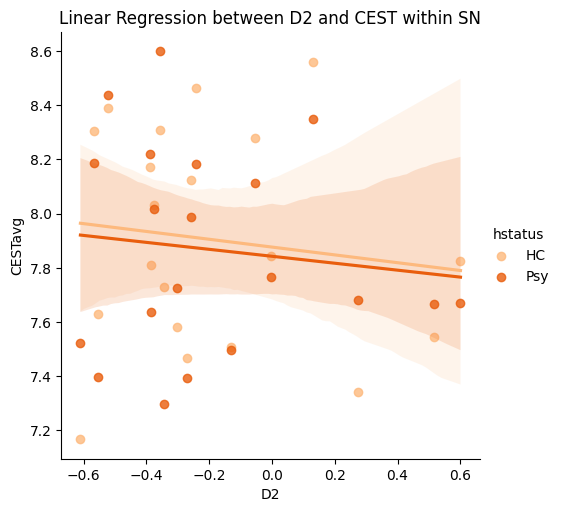

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


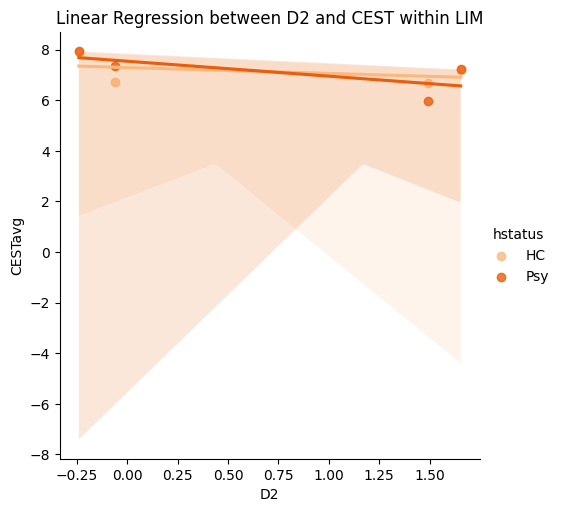

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


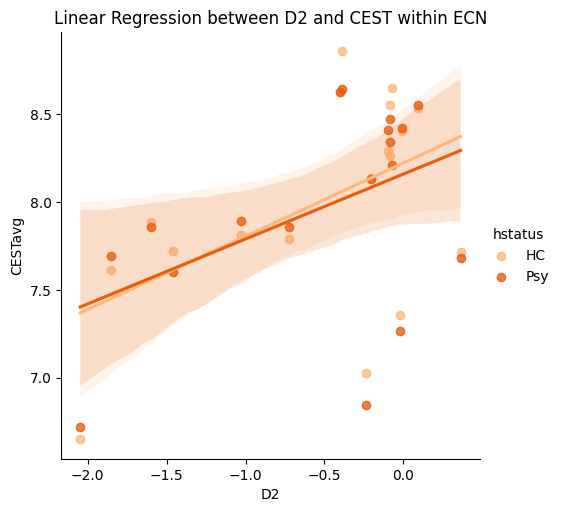

/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
/var/folders/kk/w6xmtt2d55xfbxvb6wcqhq580000gp/T/ipykernel_23242/1084623690.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'


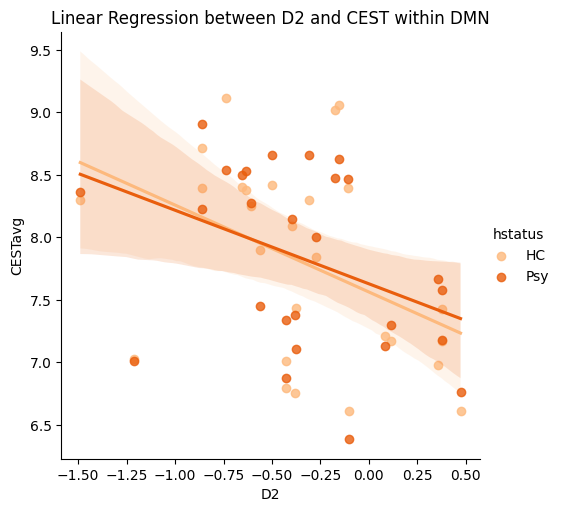

In [52]:

# Loop through nmaps and make correlation plots
#print(cestdf[CESTavg].max())


nmap_palette = {
    "NMDA": "Purples",   # Replace with actual nmap names and desired palettes
    "mGluR5": "Reds",
    "GABA": "Greens",
    "D2": "Oranges"
    # Add more mappings as needed
}



vis = [str(x) for x in range(500,569)]
mn = [str(x) for x in range(569,659)]
da = [str(x) for x in range(659,721)]
sn = [str(x) for x in range(721,798)]
lim = [str(x) for x in range(798,829)]
ecn = [str(x) for x in range(829,911)]
dmn = [str(x) for x in range(911,980)]

network_dict = {
    'VIS': vis,
    'MN': mn,
    'DA': da,
    'SN': sn,
    'LIM': lim,
    'ECN': ecn,
    'DMN': dmn
}

print(cestdf)
for nmap in nmaps:
    for network_name, parcel_range in network_dict.items():
        graphdf = cestdf[cestdf['parcel'].str.extract('(\d+)')[0].isin(parcel_range)]
        #print(graphdf)
        #cestdf[cestdf['parcel'].str.extract('(\d+)').astype(float).between(500, 510)]
        graphdf[nmap] = pd.to_numeric(graphdf[nmap], errors='coerce')
        graphdf['CESTavg'] = pd.to_numeric(graphdf['CESTavg']) #, errors='coerce'
        plot_data = graphdf.dropna(subset=[nmap, 'CESTavg'])
        palette = nmap_palette.get(nmap) # Default to "Set1" if nmap not in dictionary
        plot = sns.lmplot(x=nmap, y='CESTavg', hue='hstatus', data=plot_data, palette=palette)
        plt.xlabel(nmap)
        plt.ylabel("CESTavg")
        plt.title('Linear Regression between ' + nmap + ' and CEST within ' + network_name)
        plt.show() 